In [1]:
#--- extract the catalog

import pandas as pd
#import matplotlib; matplotlib.use('agg')
import sys
from matplotlib import rc
import matplotlib
import matplotlib.pylab as plt
import numpy as np
from matplotlib import patches
import warnings
import matplotlib.ticker
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import datetime
#import path
from math import *
import matplotlib.dates as mdates
from matplotlib import dates
import matplotlib.dates as md
import matplotlib.cm as cm
from matplotlib.font_manager import FontProperties
import itertools
import traceback
from scipy.ndimage import gaussian_filter
import math

mpl.rcParams.update(mpl.rcParamsDefault)
warnings.filterwarnings('ignore') #--- get rid of warnings

rc('text', usetex=True)
font = {'size'   : 20}
matplotlib.rc('font', **font)

def DrawFrame(ax, (alpha_xl,alpha_xr),(alpha_yb,alpha_yt),linewidth,LOG_X=None,LOG_Y=None):
    [xlo,xhi,ylo,yhi] = ax.axis()
    if LOG_X:
        [xlo,xhi,junk,junk] = np.log10(ax.axis())
    if LOG_Y:
        [junk,junk,ylo,yhi] = np.log10(ax.axis())
    lx = xhi - xlo
    ly = yhi - ylo
    xy = [xlo - alpha_xl * lx, ylo - alpha_yb * ly]
    height = ly*(1+alpha_yb+alpha_yt)
    width = lx*(1+alpha_xl+alpha_xr)
    xy_end=[xy[0]+width,xy[1]+height]
    if LOG_X:
        xy[0] = 10 ** xy[0]
        xy_end[0] = 10 ** xy_end[0]
    if LOG_Y:
        xy[1] = 10 ** xy[1]
        xy_end[1] = 10 ** xy_end[1]
    ax.add_patch( patches.Rectangle(xy=xy, width=xy_end[0]-xy[0], 
                                    height=xy_end[1]-xy[1], linewidth=linewidth,
                                    clip_on=False,facecolor=None,edgecolor='black',fill=None) ) 
    
#--- add a new time attribute
def ConvertTime( df_in ):
    df=df_in.copy()
    df.insert(0,'date',pd.to_datetime(swarm[['year', 'month', 'day', 'hour', 'minute', 'second']]))
    df.drop(['year', 'month', 'day', 'hour', 'minute', 'second'],axis=1,inplace=True)
    return df

#--- set path
#SWARM_PATH = './dataset/Oklahoma/TableS1.csv' #--- comment if passed by argument
DIR_OUTPT = '.' #'/dataset/Oklahoma' #sys.argv[2]
DIR_OUTPT_figs = '.' #'/Users/Home/Desktop/Tmp/txt' #'/Users/Home/Dropbox/Documents/papers/microSeismicityOklahoma/figs'

#--- store
swarm = pd.read_csv( SWARM_PATH, sep = ',' ) #--- parse data

swarm = ConvertTime( swarm ) #--- add new column 'date'

#--- sort based on time
swarm.sort_values(by=['date'],inplace=True)

#--- reindex
swarm.reset_index(inplace=True,drop=True)

#--- rename cols
swarm = swarm.rename(index=str,columns={'lat':'latitude','lon':'longitude','mag':'magnitude'})

swarm.head()

,date,eventid,latitude,longitude,depth,magnitude,mag_label,dmin,gap,abs_err_h,...,rel_err_h,rel_err_z,rms,nctp,ncts,rms_ct,nccp,nccs,rms_cc,other_id
0,2013-05-05 05:45:50.610,1,35.606586,-97.261084,5.228,2.2,ML,28,247,1.88,...,25.291987,36.194237,0.02,69,80,0.071,12,14,0.003,ogs8714
1,2013-05-05 15:35:08.990,2,35.663400,-97.117599,4.191,2.3,ML,41,239,0.71,...,51.445586,88.536059,0.02,140,147,0.067,0,0,-9.000,ogs8575
2,2013-05-06 23:49:41.220,3,35.578798,-97.298077,3.899,1.9,ML,23,238,1.71,...,46.958145,95.760631,0.03,121,113,0.072,0,0,-9.000,ogs8558
3,2013-05-07 01:24:01.010,4,35.559407,-97.300820,4.577,1.8,ML,28,311,1.36,...,323.613127,504.077479,0.03,76,132,0.087,0,0,-9.000,ogs8672
4,2013-05-07 07:46:07.510,5,35.542460,-97.153658,4.717,2.2,ML,30,248,0.66,...,602.014703,1535.566696,0.02,85,65,0.120,0,0,-9.000,ogs8600


In [2]:
#--- remove nan

swarm = swarm.dropna(subset=['magnitude'])
swarm.info()


<class 'pandas.core.frame.DataFrame'>
Index: 18608 entries, 0 to 18608
Data columns (total 21 columns):
date         18608 non-null datetime64[ns]
eventid      18608 non-null int64
latitude     18608 non-null float64
longitude    18608 non-null float64
depth        18608 non-null float64
magnitude    18608 non-null float64
mag_label    18603 non-null object
dmin         18608 non-null int64
gap          18608 non-null int64
abs_err_h    18608 non-null float64
abs_err_z    18608 non-null float64
rel_err_h    18608 non-null float64
rel_err_z    18608 non-null float64
rms          18608 non-null float64
nctp         18608 non-null int64
ncts         18608 non-null int64
rms_ct       18608 non-null float64
nccp         18608 non-null int64
nccs         18608 non-null int64
rms_cc       18608 non-null float64
other_id     18608 non-null object
dtypes: datetime64[ns](1), float64(11), int64(7), object(2)
memory usage: 3.1+ MB


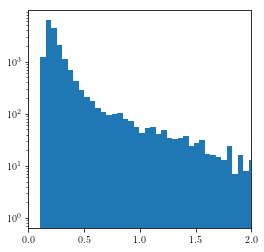

In [3]:
plt.figure(figsize=(4,4))
plt.hist(swarm['abs_err_h'],bins=1024)
plt.xlim(0,2)
plt.yscale('log')

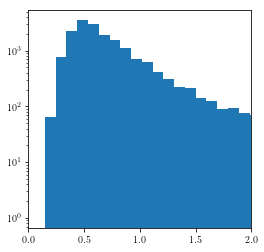

In [4]:
plt.figure(figsize=(4,4))
plt.hist(swarm['abs_err_z'],bins=1024)
plt.xlim(0,2)
plt.yscale('log')

In [5]:
swarm['abs_err_z'].mean()

1.2047355975924334

(35.8, 36)

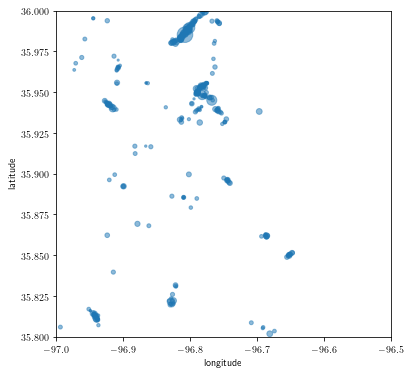

In [6]:
#--- plot spatial map 
#--- fault map california: temporal evolution of events


def DataFrameSubSet( df, column, (xmin,xmax) ):
    return df[ ( df[column] >= xmin ) & 
               ( df[column] < xmax ) ]

#--- subset of data
swarm_lohi = swarm.copy()#DataFrameSubSet( swarm, 
                          #   'date', 
                           #  ( pd.to_datetime('2010-04-04'), pd.to_datetime('2010-06-26') ) )

#swarm_lohi = DataFrameSubSet( swarm, 
#                             'longitude', 
#                            (-98,-97.9))

#swarm_lohi = DataFrameSubSet( swarm, 
#                             'latitude', 
#                            (37.2,37.3))

        
swarm_lohi.plot.scatter('longitude','latitude', figsize=(6,6),
                        s=3**(swarm_lohi['magnitude']),alpha=0.5)#,
#                        c='date',cmap='jet',alpha=0.1) #--- plot

plt.xlim(-97,-96.5)
plt.ylim(35.8,36)

#plt.savefig('%s/map.png'%DIR_OUTPT_figs,dpi=150,bbox_inches='tight')

#plt.figure(figsize=(6,6)).gca(projection='3d')
#plt.xlabel('Long')
#plt.ylabel('Lat')
#plt.scatter(swarm_lohi['longitude'],
#            swarm_lohi['latitude'],
#            swarm_lohi['depth']) #s=10*swarm['magnitude'],cmap='jet') #--- plot
#plt.show()

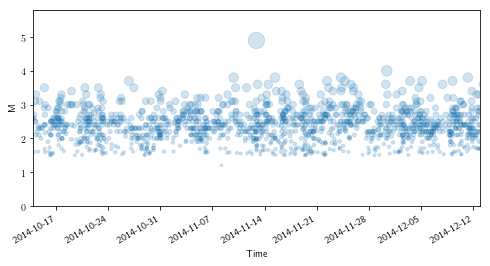

In [7]:
#--- plot timeseries


class Tlohi:
    def __init__(self,lo,hi):
        self.lo = lo
        self.hi = hi

fig=plt.figure(figsize=(8,4))
ax=fig.add_subplot(111)
plt.xlabel('Time')
plt.ylabel('M')

plt.ylim(swarm['magnitude'].min(),swarm['magnitude'].max())

tt=swarm[swarm['magnitude']==swarm['magnitude'].sort_values(ascending=False).iloc[3]]['date']
plt.xlim(tt-datetime.timedelta(days=30),tt+datetime.timedelta(days=30))# pd.to_datetime('2014-12-04'),pd.to_datetime('2015-06-1'))
#plt.xlim(swarm['date'].min(),pd.to_datetime('2010-07-20'))
plt.scatter(swarm['date'],swarm['magnitude'],
            s=2*np.exp(swarm['magnitude']),
            alpha=0.2)

#myTlohi = Tlohi( pd.to_datetime('2010-04-08'), 
#                 pd.to_datetime('2010-07-01'))

#plt.plot([myTlohi.lo,myTlohi.lo],
#        [-2,7],'r-')

#plt.plot([myTlohi.hi,myTlohi.hi],
#        [-2,7],'r-')
fig.autofmt_xdate()
plt.savefig('%s/timeSeries.png'%DIR_OUTPT_figs,dpi=150,bbox_inches='tight')


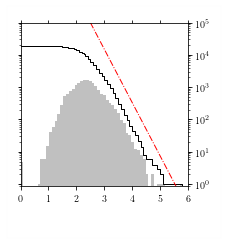

In [8]:
#--- freq-magnitude relation

import sys 

def histogramACCUMLTD( slist ):
    assert type( slist ) == type( [] ), 'arg must be a list. a %s is given!' %( type( slist ) )
    d = {}
    for item in slist:
        try:
            d[ item ] += 1
        except:
            d[ item ] = 1
    keys = d.keys()
    keys.sort()

    cdf = 0.0
    xi = min( slist ) - 1.0e-6
    xf = max( slist ) + 1.0e-6
    npoin = len( slist )
    adict = {}
    for ikey, index in zip( keys, xrange( sys.maxint ) ):
        adict[ index ] = [ xi, ikey, cdf ]
        cdf += 1.0 * d[ ikey ] # / npoin
        xi = ikey
    adict[ index + 1 ] = [ xi, xf, cdf ]
    return adict





#--- set min/max time to avoid temporal incompletenesss issue
swarm_copy = swarm.copy()#DataFrameSubSet( swarm, 
                          #   'date', 
                           #  ( myTlohi.lo, 
                            #   myTlohi.hi ) )
#--- accumulated histogram
N = len(swarm_copy['magnitude'])
slist=np.array(swarm_copy['magnitude'])
slist.sort()
d = histogramACCUMLTD( slist.tolist() )
keys=d.keys()
keys.sort()

#--- plot
fig= plt.figure(figsize=(3,3))#,dpi=150)
ax = fig.add_subplot(111)

ax.axis([0,6,.9,1e5])
ax.set_yscale('log')

#--- add major xticks
xmin=np.ceil(ax.axis()[0])
xmax=np.floor(ax.axis()[1])
nbin = xmax - xmin
ax.set_xticks(np.linspace(ax.axis()[0],ax.axis()[1],int(nbin)+1))

#--- add major yticks
ymin=np.ceil(np.log10(ax.axis()[2]))
ymax=np.floor(np.log10(ax.axis()[3]))
nbin = ymax - ymin
ax.set_yticks(np.logspace(ymin,ymax,int(nbin)+1))


# #--- put minor bins
# locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1),numticks=12)
# ax.xaxis.set_minor_locator(locmin)
# ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

#--- put minor bins y
locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1),numticks=12)
ax.yaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

ax.tick_params(axis='y',left=True, right=True,which='both',labelleft=False, labelright=True)
ax.tick_params(axis='x',bottom=True, top=True,which='both')

xmin=swarm_copy['magnitude'].min()
xmax=swarm_copy['magnitude'].max()
dx=0.1
junk = ax.hist( swarm_copy['magnitude'],
                bins=int((xmax-xmin)/dx),
               label='histogram',color='silver') #--- histogram
xx=[];yy=[]
for ikey in keys:
    xx.append(d[ikey][0])
    yy.append(N-d[ikey][2])
ax.plot(xx,yy,
            linestyle='-', drawstyle='steps-post',color='black',
             linewidth=1.0) #--- accumulated
    
b=1.65    
ax.plot([2.5,6],[1e5, 1e5* 10**(-b*(6-2.5))],'r-.',linewidth=1)

DrawFrame(ax, (0.08,0.2),(0.32,0.1),0.01,LOG_Y=True) 

#plt.savefig('%s/gr.png'%DIR_OUTPT_figs,dpi=150,bbox_inches='tight')#,transparent=True)



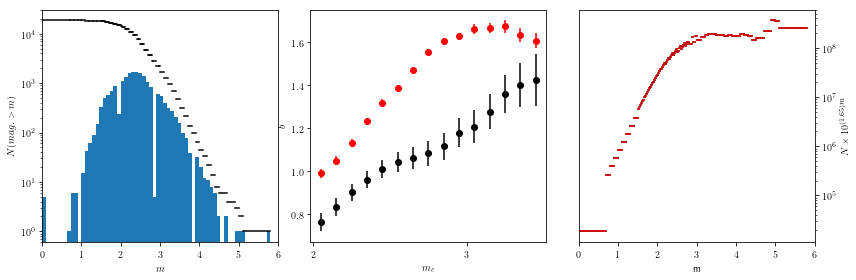

In [9]:
#--- estimate b by varying the mc value

from math import *
import scipy.stats

#--- set min/max time to avoid temporal incompletenesss issue
swarm_copy = swarm.copy()#DataFrameSubSet( swarm.copy()#, 
                          #   'date', #
                           #  ( myTlohi.#lo, 
                            #   myTlohi.hi# ) )

#--- plot distributions (Nm)
fig = plt.figure(figsize=(12,4))
ax=fig.add_subplot(131)
ax.set_xlabel('$m$')
ax.set_ylabel('$N(mag.>m)$')
xmin = 0 #np.floor(swarm_copy['magnitude'].min())
xmax = 6 #np.ceil(swarm_copy['magnitude'].min())
ax.set_xticks(np.linspace(xmin,xmax,int(xmax-xmin)/1+1))
ax.set_xlim(xmin,xmax)
#plt.ylim(1,1e5)
ax.set_yscale('log')
for ikey in keys:
    ax.plot([d[ikey][0],d[ikey][1]],
             [N-d[ikey][2],N-d[ikey][2]],
             '-',color='black') #--- accumulated
junk = ax.hist( swarm_copy['magnitude'],
                bins=64,
               label='histogram') #--- histogram

#--- list of magnitudes
mm_list = swarm_copy['magnitude'].to_list()
mm_list = np.sort(mm_list)

#--- b vs mc
ax2=fig.add_subplot(132)
ax2.set_xticks(np.linspace(-1.0,3.0,5))
#ax2.set_ylim(0,1.8)
#ax4 = ax2.twinx()
#ax4.set_yscale('log')
#ax4.set_ylim(1e-16,)
#plt.xlim(0.0,1.5)
ax2.set_xlabel('$m_c$')
ax2.set_ylabel('$b$')
#ax4.set_ylabel(r'$p_{val}$',labelpad=-70)

#--- bvalue bhatacharya eq. 5
DM = 0.1
n = 15
#--- 
MC = []
B = []
Err_B = []
pval = []
for mc_new in [2.05+i*0.1 for i in xrange(n)]: #--- m values are quantized (+- 0.1)!
    mlist = swarm_copy[ swarm_copy['magnitude']-mc_new>=0.0]['magnitude'] 
    m_mean=mlist.mean()
    assert m_mean-mc_new > 0.0, 'm_mean=%s,mc=%s'%( m_mean, mc )
    k_mean = (m_mean-mc_new)/DM
    b_value = log(np.exp(1),10)*log(1+DM/(m_mean-mc_new))/DM
    nsamp = len(mlist)
#    err_b = 1.96*(b_value/nsamp/log(10,exp(1.0)))**0.5
    err_b = 2*(k_mean*(k_mean+1)/nsamp)**0.5/log(10,exp(1.0)) #--- Guttorp and Hopkins (1986) eq.(4)

    
    
    #--- bvalue bhatacharya eq. 6
    #--- accumulated histogram
    slist = mm_list[ mm_list>=mc_new ]
    slist.sort()
    NN = len(slist)
    cdf = histogramACCUMLTD( slist.tolist() )
    #--- bvalue bhatacharya eq. 6
    n_cdf=len(cdf)-1
    bi = []
    for i in xrange(n_cdf):
        mi = cdf[ i ][ 0 ]
        Ni = NN - cdf[ i ][ 2 ]
        bij = []
        for j in xrange(n_cdf):
            mj = cdf[ j ][ 0 ]
            Nj = NN - cdf[ j ][ 2 ]
            if i == j: continue
            slope = ( log( Nj, 10 ) - log( Ni, 10 ) ) / ( mj - mi )
            assert not np.isnan(slope)
            bij.append( slope )
        bi.append( np.median( bij ) )
    bval_2nd = -np.median( bi )
    err_b2nd = np.std(bi)/(len(bi))**0.5
    
    #--- plot b vs mc
    ax2.errorbar([mc_new],[b_value],yerr=err_b,marker='o',color='black')
    ax2.errorbar([mc_new],[bval_2nd],yerr=err_b2nd, marker='o',color='red')
    
    #---
    MC.append(mc_new)
    B.append(b_value)
    Err_B.append(err_b)

    #--- p-value (by hand)
#    (dmax,pval2nd) = scipy.stats.kstest( mlist, lambda x: 1.0-10**(-b_value*(x-mc_new)))
#    ax4.plot([mc_new],[pval2nd],marker='o',color='red')
#    pval.append(pval2nd)

#--- choose the range of mc
mc_range=[1.0,2.0]
index_tf = [i and j for i, j in zip(mc_range[0]<=np.array(MC),np.array(MC)<mc_range[1])]
bvall =  np.array(B)[index_tf]
Err_B =  np.array(Err_B)[index_tf]

#--- b vs mc: vertical lines
#ax2.plot([mc_range[0],mc_range[0]],[np.min(B),np.max(B)],'--r')    
#ax2.plot([mc_range[1],mc_range[1]],[np.min(B),np.max(B)],'--r')    

#--- N vs m: vertical line
#ax.plot([mc_range[0]+DM/2,mc_range[0]+DM/2],
 #       [1,len(swarm_copy['magnitude'])],'--r')    

#--- n*10*bm (rescaled)
bval=1.65 #np.mean(bvall)
bval2=1.65
ax3=fig.add_subplot(133)
ax3.set_xlabel('m')
#ax3.set_ylabel(r'$N\times10^{%s\times m}$'%bval)
ax3.set_ylabel(r'$N\times10^{(%s)m}$'%bval)
ax3.yaxis.set_label_position("right")
ax3.yaxis.tick_right()
ax3.set_yscale('log')
ax3.set_xticks(np.linspace(xmin,xmax,int(xmax-xmin)/1+1))
ax3.set_xlim(xmin,xmax)
#ax3.set_ylim(1e3,1e6)
#ax3.set_xticks(np.linspace(ax3.axis()[0],ax3.axis()[1],4))
for ikey in keys: #--- rescaled
    c = 10**(bval*d[ikey][0])
    ax3.plot([d[ikey][0],d[ikey][1]],
             [c*(N-d[ikey][2]),c*(N-d[ikey][2])],'-',color='black',
            ) #--- accumulated
    c = 10**(bval2*d[ikey][0])
    ax3.plot([d[ikey][0],d[ikey][1]],
             [c*(N-d[ikey][2]),c*(N-d[ikey][2])],'-',color='red',
             ) #--- accumulated
# ax3.plot([mc_range[0]+DM/2,mc_range[0]+DM/2], #--- vertical line
#         [len(swarm_copy[swarm_copy['magnitude']>mc_range[0]])*10**(bval*mc_range[0])/10,
#          len(swarm_copy[swarm_copy['magnitude']>mc_range[0]])*10**(bval*mc_range[0])],'--r')    
#plt.plot(MC, pval,'-o',color='black')

fig.tight_layout(w_pad=-0.5)
#fig.savefig('%s/b.png'%DIR_OUTPT_figs,dpi=75)



In [10]:
##--- estimate b and mc
#
#
#with path.Path('/Users/Home/Desktop/Tmp/txt/myPYlibs'):
#    import plfit
#    import plvar
#    import plpva
#
##--- set min/max time to avoid temporal incompletenesss issue
#swarm_copy = swarm.copy()#DataFrameSubSet( swarm, 
#                          #   'date', 
#                           #  ( myTlohi.lo, 
#                            #   myTlohi.hi ) )
#
##--- power law fit clauset
#n_samp = 1000
#n_chunk = len( swarm_copy ) / n_samp
#
#i = 0
#fig = plt.figure(figsize=(8,4))
#ax = fig.add_subplot(111)
#ax.set_ylabel('m')
#ax2=ax.twinx()
#ax.scatter(swarm_copy['date'],swarm_copy['magnitude'],
#          alpha=0.1)
#
#fig2 = plt.figure(figsize=(8,4))
#ax21 = fig2.add_subplot(111)
#ax21.set_ylabel('m')
#ax21.scatter(swarm_copy['date'],swarm_copy['magnitude'],
#          alpha=0.1)
#
#MC = []
#B = []
#for j in xrange(n_chunk):
#    Mlist = 10**(swarm_copy.iloc[i:i+n_samp]['magnitude'])
#    fit = plfit.plfit( np.array(Mlist) ) #--- clauset
#    mc = log(fit[1],10) #--- completeness mag.
#    bval = fit[0]-1
#    MC.append(mc)
#    B.append(bval)
##    print mc, bval
#    ax2.plot([swarm_copy.iloc[i:i+n_samp]['date'].min(),swarm_copy.iloc[i:i+n_samp]['date'].max()],
#            [bval,bval],'-',color='red')
#
#    ax21.plot([swarm_copy.iloc[i:i+n_samp]['date'].min(),swarm_copy.iloc[i:i+n_samp]['date'].max()],
#            [mc,mc],'-',color='red')
#
#    i += n_samp
#Mlist = 10**(swarm_copy.iloc[i:i+len(swarm_copy)%n_samp]['magnitude'])
#fit = plfit.plfit( np.array(Mlist) ) #--- clauset
#mc = log(fit[1],10) #--- completeness mag.
#bval = fit[0]-1
#MC.append(mc)
#B.append(bval)
#
##---- plot bval
#ax2.plot([swarm_copy.iloc[i:i+n_samp]['date'].min(),swarm_copy.iloc[i:i+n_samp]['date'].max()],
#            [bval,bval],'-',color='red')
#ax2.tick_params(colors='red')
#ax2.set_ylabel('b',color='red')
#ax.set_xlabel('Date')
##print mc, bval
##fig.savefig('%s/b.png'%DIR_OUTPT_figs,dpi=75)
##--- plot mc
#ax21.plot([swarm_copy.iloc[i:i+n_samp]['date'].min(),swarm_copy.iloc[i:i+n_samp]['date'].max()],
#            [mc,mc],'-',color='red',label='mc')
#plt.legend()
#ax21.set_xlabel('Date')
#
##n, bins, patches = plt.hist(B, 50)
#
##--- error estimate
##[ error_b, error_mc, ntail ] = [ 0.0, 0.0, 0.0 ]
##[error_b, error_mc, ntail] = plvar.plvar(np.array(Mlist), 'silent')
##error_mc = log(1.0+error_mc/fit[1],10) #--- log(1+dM/M)
#plt.savefig('%s/mc.png'%DIR_OUTPT_figs,dpi=75)

In [11]:
# #--- goodness of the fit

# n_samp = 1000
# n_chunk = len( swarm_copy ) / n_samp
# ncols=4
# nrows = n_chunk / ncols + int(np.ceil(1.0*( len(swarm_copy) % n_samp) / n_samp))
# i = 0
# plt.figure(figsize=(ncols*4,nrows*4))
# for j in xrange(n_chunk):
#     Mlist = 10**(swarm_copy.iloc[i:i+n_samp]['magnitude'])
#     fit = plfit.plfit( np.array(Mlist) ) #--- clauset
#     mc = log(fit[1],10) #--- completeness mag.
#     bval = fit[0]-1
# #    [error_b, error_mc, ntail] = plvar.plvar(Mlist, 'silent') #--- error
#     plt.subplot(nrows,ncols,j+1)
#     Mlist=np.log10(Mlist)
#     nc = len(Mlist[Mlist>=mc])
#     error_b = (bval / nc / log(10.0) )**0.5
#     hist,bins = np.histogram(Mlist,bins=1024)
#     plt.plot(bins[:-1],-hist.cumsum()+len(Mlist))#,marker='o',markersize=6,linestyle='None')
#     xc=0.5*(bins[:-1]+bins[1:])
#     plt.plot(xc, len(Mlist[Mlist>=mc])*10**(-bval*(xc-mc)),'r',label='$b=%2.1f\pm%3.2f$'%(bval,error_b))
#     plt.plot([mc,mc],[1,len(Mlist[Mlist>=mc])],label='$mc=%2.1f$'%(mc)) # len(Mlist[Mlist>=mc])*10**(-bval*(xc-mc)),'r')
#     plt.yscale('log')
#     plt.xlim(swarm_copy['magnitude'].min(),swarm_copy['magnitude'].max())
#     plt.ylim(1,n_samp*10)
#     if j == 0:
#         plt.ylabel('N(size>m)')
#         plt.xlabel('m')
#     plt.legend()
#     i += n_samp

# Mlist = 10**(swarm_copy.iloc[i:i+len(swarm_copy)%n_samp]['magnitude'])
# fit = plfit.plfit( np.array(Mlist) ) #--- clauset
# mc = log(fit[1],10) #--- completeness mag.
# bval = fit[0]-1
# Mlist=np.log10(Mlist)
# nc = len(Mlist[Mlist>=mc])
# error_b = (bval / nc / log(10.0) )**0.5
# hist,bins = np.histogram(Mlist,bins=1024)

# plt.subplot(nrows,ncols,j+2)
# plt.plot(bins[:-1],-hist.cumsum()+len(Mlist))#,marker='o',markersize=6,linestyle='None')
# xc=0.5*(bins[:-1]+bins[1:])
# plt.plot(xc, len(Mlist[Mlist>=mc])*10**(-bval*(xc-mc)),'r',label='$b=%2.1f\pm%3.2f$'%(bval,error_b))
# plt.plot([mc,mc],[1,len(Mlist[Mlist>=mc])],label='$m_c=%2.1f$'%(mc)) # len(Mlist[Mlist>=mc])*10**(-bval*(xc-mc)),'r')
# plt.yscale('log')
# plt.xlim(swarm_copy['magnitude'].min(),swarm_copy['magnitude'].max())
# plt.ylim(1,n_samp)
# plt.legend()

# plt.savefig('%s/b_mult.png'%DIR_OUTPT_figs,dpi=75,bbox_inches='tight')
    

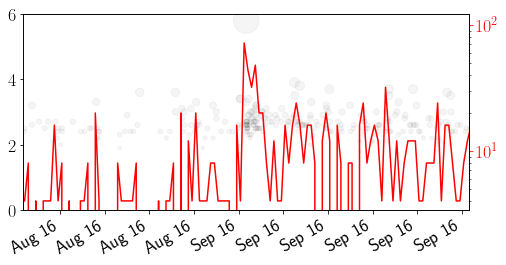

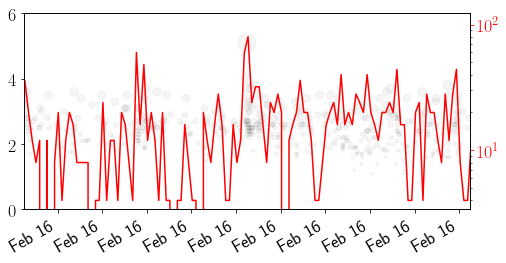

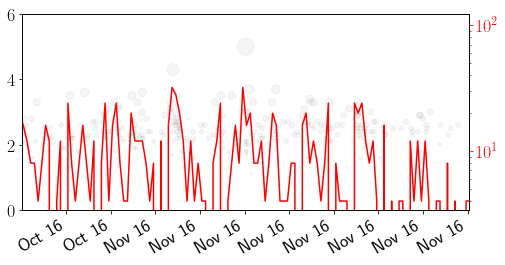

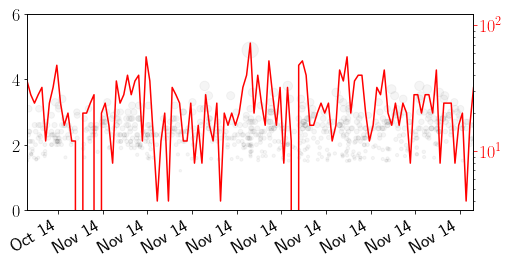

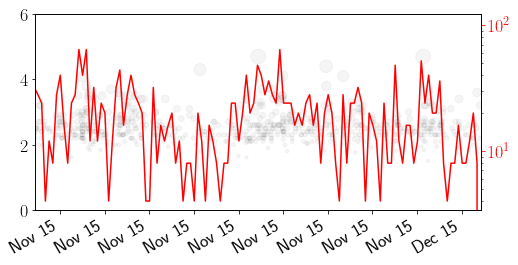

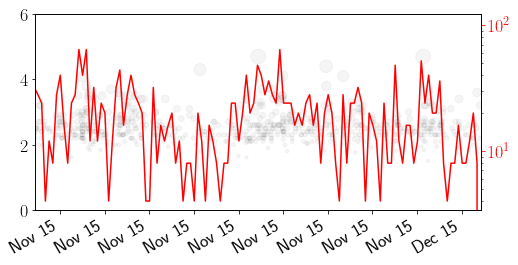

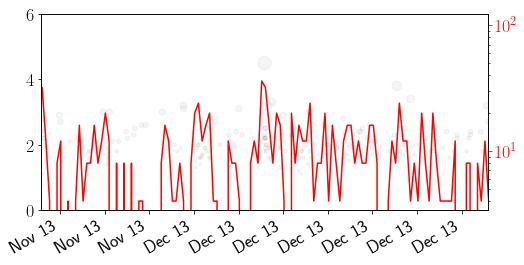

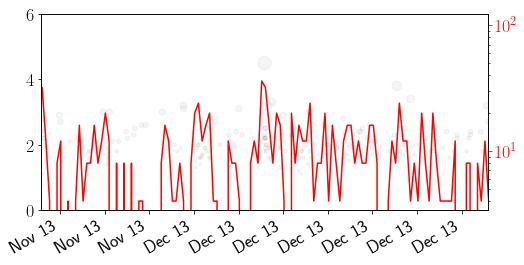

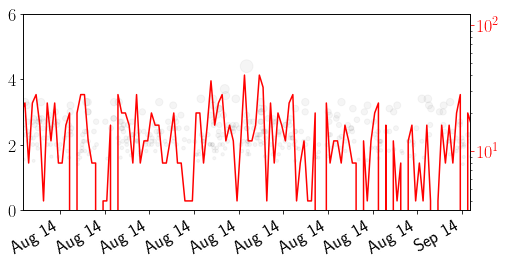

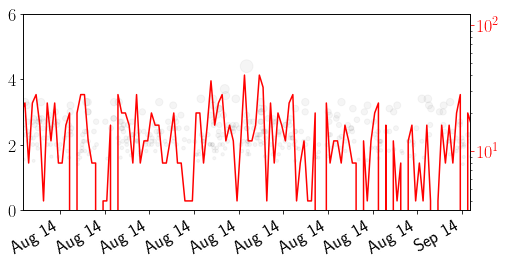

In [12]:
#--- plot complete catalog

def ConvertDailyRate(hist, bin_edges ):
#---convert data to daily rate     
    t0 = pd.to_datetime( bin_edges[ 0 ] )
    t1 = pd.to_datetime( bin_edges[ 1 ] )
    delta_t = ( t1 - t0 ).total_seconds() / ( 60 * 60*24)
    hist *= ( bin_edges[ 1 ] - bin_edges[ 0 ] ) / delta_t

def ActivityRate( swarm ):
    nbins = int( (swarm['date'].max()-swarm['date'].min()).days*4 ) #--- number of bins
    
    tmax = swarm['date'].max().value #--- min/max
    tmin = swarm['date'].min().value
    
    hist, bin_edges = np.histogram(swarm['date'].apply(lambda x:x.value),                                   
                    bins=np.linspace(tmin,tmax,nbins+1,endpoint=True),density=True) #--- probability dist.
    hist *= len( swarm['date'] ) #--- int(hist).dt=n
    cumm_number = np.cumsum(hist)*(bin_edges[1]-bin_edges[0]) #--- accumulated number
    ConvertDailyRate( hist, bin_edges ) #--- daily activity
    return bin_edges, hist, cumm_number
    
    
#---------------------------------------------------------------------------------
#-----------------
#-----------------
#-----------------
#---------------------------------------------------------------------------------
   
#--- completeness
mc = 2.8



#--- t0<t<t1
#--- set min/max time to avoid temporal incompletenesss issue
swarm_tmp = swarm.copy()#DataFrameSubSet( swarm, 
                         #    'date', 
                          #   ( swarm['date'].min(), 
                           #    pd.to_datetime('2010-07-31') ) )
#--- m > mc
swarm_lohi = swarm_tmp.copy() #DataFrameSubSet( swarm_tmp, 
                            # 'magnitude', 
                             #( mc, sys.maxint ) ) 

#--- spatial map
#swarm_lohi.plot.scatter('longitude','latitude',
#                        s=3**(swarm_lohi['magnitude']),
#                        c='date',cmap='jet',
#                        alpha = 0.4) #--- plot
    
#--- temporal map
#ax1.set_xlim(swarm_tmp['date'].min(),swarm_tmp['date'].max())
for ii in xrange(10):
    fig = plt.figure(figsize=(8,4))
    ax1=fig.add_subplot(111)

    #plt.xlabel('Time')
    #plt.ylabel('M')

    ax1.set_ylim(0,6)
    tt=swarm[swarm['magnitude']==swarm['magnitude'].sort_values(ascending=False).iloc[ii]]['date'].iloc[0]
    ax1.set_xlim(tt-datetime.timedelta(days=15),tt+datetime.timedelta(days=15))# pd.to_datetime('2014-12-04'),pd.to_datetime('2015-06-1'))
    
    ax1.tick_params(axis='both',labelsize=18)
    #ax1.tick_params(axis='x',rotation=18)
    
    ax1.scatter(swarm_lohi['date'],swarm_lohi['magnitude'],
                s=2*np.exp(swarm_lohi['magnitude']),
                alpha=0.04,color='black')
        
    #--- activity rate
    bin_edges, hist, cumm_number = ActivityRate( swarm_lohi )
    
    #--- plot
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.plot(pd.to_datetime(bin_edges[:-1]),hist,'r-')
    
    ax2.tick_params(axis='y',labelsize=18,colors='red')
    
    ax2.set_yscale('log')
    
    #ax2.set_ylim(1e1,1e3)
    
    ax2.xaxis.set_major_formatter(dates.DateFormatter('%b %y'))
    
    fig.autofmt_xdate()

#fig.savefig('%s/timeSeries_ok.png'%DIR_OUTPT_figs,bbox_inches='tight')


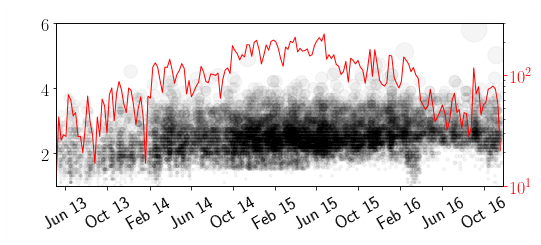

In [13]:
#--- plot complete catalog

def ConvertDailyRate(hist, bin_edges ):
#---convert data to daily rate     
    t0 = pd.to_datetime( bin_edges[ 0 ] )
    t1 = pd.to_datetime( bin_edges[ 1 ] )
    delta_t = ( t1 - t0 ).total_seconds() / ( 60 * 60 * 24 * 7)
    hist *= ( bin_edges[ 1 ] - bin_edges[ 0 ] ) / delta_t

def ActivityRate( swarm ):
    nbins = int( (swarm['date'].max()-swarm['date'].min()).days / 7 ) #--- number of bins
    
    tmax = swarm['date'].max().value #--- min/max
    tmin = swarm['date'].min().value
    
    hist, bin_edges = np.histogram(swarm['date'].apply(lambda x:x.value),                                   
                    bins=np.linspace(tmin,tmax,nbins+1,endpoint=True),density=True) #--- probability dist.
    hist *= len( swarm['date'] ) #--- int(hist).dt=n
    cumm_number = np.cumsum(hist)*(bin_edges[1]-bin_edges[0]) #--- accumulated number
    ConvertDailyRate( hist, bin_edges ) #--- daily activity
    return bin_edges, hist, cumm_number
    
    
#---------------------------------------------------------------------------------
#-----------------
#-----------------
#-----------------
#---------------------------------------------------------------------------------
   
#--- completeness
mc = 2.8



#--- t0<t<t1
#--- set min/max time to avoid temporal incompletenesss issue
swarm_tmp = swarm.copy()#DataFrameSubSet( swarm, 
                         #    'date', 
                          #   ( swarm['date'].min(), 
                           #    pd.to_datetime('2010-07-31') ) )
#--- m > mc
swarm_lohi = swarm_tmp.copy() #DataFrameSubSet( swarm_tmp, 
                            # 'magnitude', 
                             #( mc, sys.maxint ) ) 

#--- spatial map
#swarm_lohi.plot.scatter('longitude','latitude',
#                        s=3**(swarm_lohi['magnitude']),
#                        c='date',cmap='jet',
#                        alpha = 0.4) #--- plot
    
#--- temporal map
fig = plt.figure(figsize=(8,3))#,dpi=150)
ax1=fig.add_subplot(111)

#plt.xlabel('Time')
#plt.ylabel('M')

ax1.set_ylim(1,6)
ax1.set_xlim(swarm_tmp['date'].min(),swarm_tmp['date'].max())

ax1.tick_params(axis='both',labelsize=18)
ax1.tick_params(axis='x',rotation=30)

ax1.scatter(swarm_lohi['date'],swarm_lohi['magnitude'],
            s=2*np.exp(swarm_lohi['magnitude']),
            alpha=0.04,color='black')

DrawFrame(ax1, (0.11,0.07),(0.32,0.1),0.01)

#--- activity rate
bin_edges, hist, cumm_number = ActivityRate( swarm_lohi )

#--- plot
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(pd.to_datetime(bin_edges[:-1]),hist,'r-',linewidth=1)

ax2.tick_params(axis='y',labelsize=18,colors='red')

ax2.set_yscale('log')

ax2.set_ylim(1e1,3e2)

ax2.xaxis.set_major_formatter(dates.DateFormatter('%b %y'))

#fig.autofmt_xdate(bottom=.1)

#fig.savefig('%s/timeSeries_ok.png'%DIR_OUTPT_figs,dpi=150,bbox_inches='tight')


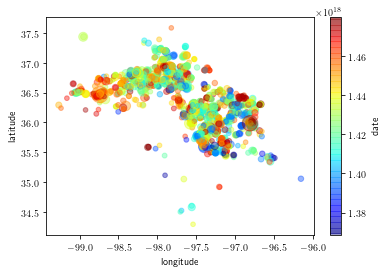

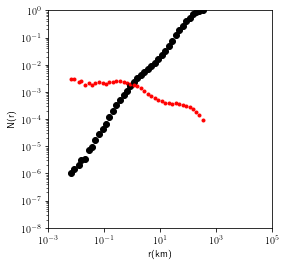

In [14]:
#--- evaluate fractal dimension

import geopy.distance
from math import *
import random as rnd

class bins:
    def __init__(self, nBin, xlo, xhi, ydim = 1, err = None):
        self.lo = xlo - 1.0e-10
        self.hi = xhi + 1.0e-10
        self.dx = (self.hi-self.lo)/nBin
        self.xlist = [0.0 for i in xrange(nBin)]
        self.kounter = [0 for i in xrange(nBin)]
        self.ylist = [[0.0 for j in xrange(ydim)] for i in xrange(nBin)]
        self.nBin = nBin
        self.err = err
        self.max_y = [[-sys.maxint for j in xrange(ydim)] for i in xrange(nBin) ]
        self.min_y = [[sys.maxint for j in xrange(ydim)] for i in xrange(nBin)]
        if err:
            self.ySQlist = [[0.0 for j in xrange(ydim)] for i in xrange(nBin)]
    def GetBin(self,x):
        return int(floor((x-self.lo)/self.dx))
    def whichBin(self,x,y, ibin=[] ):
        assert x >= self.lo, 'x=%s,self.lo=%s'%(10**x,10**self.lo)
        assert x < self.hi, 'x=%s,self.hi=%s'%(10**x,10**self.hi)
        nr = int(floor((x-self.lo)/self.dx))
        if ibin:
            ibin[ 0 ] = nr
        self.kounter[nr] += 1
        self.xlist[nr] += x
        for idim in xrange(len(y)):
            self.ylist[nr][idim] += y[idim]
            if y[idim] >= self.max_y[nr][idim]: #--- set max value
                self.max_y[nr][idim]=y[idim]
            if y[idim] <= self.min_y[nr][idim]:
                self.min_y[nr][idim]=y[idim]
            if self.err:
                self.ySQlist[nr][idim] += y[ idim ] * y[ idim ]

    def res(self, logScaleX = None, logScaleY = None, base = 10, SUM = None, MINMAX=None ):
         indices = xrange(10**6)
         someList = []
         for x,index in zip(self.xlist,indices):
             nb = self.kounter[index]
             if nb == 0: continue
             xbar = self.xlist[index]/nb
             ybar = [y/nb for y in self.ylist[index]]
             if self.err:
                 sigmaY = [ ( ysq / nb - YBAR * YBAR ) ** 0.5 / nb ** 0.5 for ysq, YBAR in zip( self.ySQlist[ index ], ybar )]
                 if SUM:
                     sigmaY = [ i * nb for i in sigmaY ]
             if SUM:
                 ybar = [y for y in self.ylist[index]]
             if MINMAX:
                 MAX_y = [y for y in self.max_y[index]]
             if logScaleX:
                 xbar = base ** xbar
             if logScaleY:
                 ybar = [ base ** item for item in ybar ]
             if self.err:
                 someList.append([ xbar, ybar, sigmaY ])
             elif MINMAX:
                 someList.append([ xbar, ybar, MAX_y ])
             else:
                 someList.append([ xbar, ybar ])
         return someList


class histogram( bins ):
    def res( self, Radial = None, logScale = None, normalize = True, base = 10.0, ACCUMLTD = None ):
        PDF = []
        self.nPoint = nPoint = sum( self.kounter )
        indices = xrange( sys.maxint )
        y_accm = nPoint
        for y, index in zip( self.kounter, indices ):
            if not ACCUMLTD and y == 0:
                continue
            if not y == 0:
                x = self.xlist[ index ] / y #self.lo + index * self.dx
            else:
                x = self.lo + index * self.dx
            Y = 1.0 * y
            dx = self.dx
            if logScale:
                x = base ** x
                dx = x * ( base ** self.dx - 1.0 )
#               print Y, dx
            if normalize:
                Y /= ( nPoint * dx )
                if Radial:
                    Y /= ( 2.0 * pi * x )
#           PDF.append( [ x, Y ] )
#           PDF.append( [ x + dx, Y ] )
#           PDF.append( [ x + 0.5 * dx, Y, 0.0, ( 1.0 * y_accm / nPoint if normalize else 1.0 * y_accm )  ] )
            error_std = 0.0
            if self.err:
                error_std = sqrt( nPoint * Y * dx ) / ( nPoint * dx ) #--- poisson
                error_std = sqrt( nPoint * Y * dx * ( 1.0 - Y * dx ) ) / ( nPoint * dx ) #--- bi-nomial
            PDF.append( [ x, Y, 0.0, ( 1.0 * y_accm / nPoint if normalize else 1.0 * y_accm ), error_std ] )
            y_accm -= y
        return PDF

def GetCartesian( dff ):
    df = dff.copy()
    xlo = df['longitude'].min()
    xhi = df['longitude'].max()
    ylo = df['latitude'].min()
    yhi = df['latitude'].max()
    getDistX = lambda x: geopy.distance.vincenty( ( 0.0, xlo ), ( 0.0, x ) ).km
    getDistY = lambda y: geopy.distance.vincenty( ( ylo, 0.0 ), ( y, 0.0 ) ).km
    df[ 'x(km)' ] = df[ 'longitude' ].apply( getDistX ) 
    df[ 'y(km)' ] = df[ 'latitude' ].apply( getDistY ) 
    df[ 'z(km)' ] = df['depth']
    return df

def fractalDimension2nd( coord ):
    #--- sort
    if type( coord ) == type( [] ):
        coord = ListToDict( coord )
    points = coord.keys()
    points.sort()
    hsObject = histogram( 18 * 8, log( 1e-10,10), log( 1e8, 10 ) )
    for point_i in points:
        for point_j in points:
            if not point_i < point_j: #--- pairs ij with i<j
                continue
            rij = sum( [ ( i - j ) ** 2 for i, j in zip( coord[ point_i ], coord[ point_j ] ) ] ) # ** 0.5
            assert rij > 0, 'rij=%s,coord[ %s ]=%s, coord[ %s ]=%s' %(rij,point_i,coord[ point_i ], point_j, coord[ point_j ] )
            hsObject.whichBin( 0.5 * log( rij,10 ), [ 1.0 ] )
    for items in hsObject.res( logScale = True, normalize = True, ACCUMLTD = True ):
        if items[ 3 ] > 0.0: 
            yield items[ 0 ], items[ 3 ]

#---------------------------------------------------------------------------------
#-----------------
#-----------------
#-----------------
#---------------------------------------------------------------------------------


#--------------------
#----- subset
#--------------------
swarm_lohi = DataFrameSubSet( swarm, #--- complete catalog
                             'magnitude', 
                             ( mc, sys.maxint ) ) 
swarm_lohi = swarm_lohi.sample( n = 2000 ) #--- sample

#--------------------
#--- cartesian coords
#--------------------
swarm_cartesian = GetCartesian( swarm_lohi )

#--------------------
#--- evaluate df
#--------------------
tmp_coord = swarm_cartesian['x(km)'].apply(lambda x: [x+rnd.random()*1e-6]) +\
            swarm_cartesian['y(km)'].apply(lambda x: [x+rnd.random()*1e-6]) +\
            swarm_cartesian['z(km)'].apply(lambda x: [x+rnd.random()*1e-6])
tmp_coord = tmp_coord.to_dict()
dict_NR = fractalDimension2nd( tmp_coord ) #, dmin = 1.0e-02 )

#--------------------
#--- scattered plot
#--------------------
swarm_cartesian.plot.scatter('longitude','latitude',
                        s=3**(swarm_lohi['magnitude']),
                        c='date',cmap='jet',
                        alpha = 0.4) 

#--------------------
#--- N(r) vs r
#--------------------
plt.figure( figsize = (4,4))
plt.xlabel('r(km)')
plt.ylabel('N(r)')
plt.xlim(1e-3,1e5)
plt.ylim(1e-8,1)
plt.yscale('log')
plt.xscale('log')
d_f = 1.6
for i in dict_NR:
    plt.plot([i[ 0 ]],
             [1-i[ 1 ]],
             'o',color='black') #--- accumulated
    plt.plot(i[ 0 ],
             (1-i[ 1 ])/i[0]**d_f,
             '.',color='red') #--- accumulated

In [15]:
#--- evaluate fractal dimension (correltion dimension )

def getRmat2d( df_complete ):
    nmax = len( df_complete )
    rmat = np.matrix(np.zeros(nmax*nmax).reshape(nmax,nmax))
    for i in xrange( nmax ):
        #--- distance matrix
        df_dx = df_complete[ 'x(km)' ] - df_complete[ 'x(km)' ][ i ]
        df_dy = df_complete[ 'y(km)' ] - df_complete[ 'y(km)' ][ i ]
        df_sq = ( df_dx*df_dx+df_dy*df_dy ) ** 0.5
        df_sq[ : i ] = 0
        rmat[ i ] = np.array(df_sq)
    return np.array( rmat ) 

def getRmat3d( df_complete ):
    nmax = len( df_complete )
    rmat = np.matrix(np.zeros(nmax*nmax).reshape(nmax,nmax))
    for i in xrange( nmax ):
        #--- distance matrix
        df_dx = df_complete[ 'x(km)' ] - df_complete[ 'x(km)' ][ i ]
        df_dy = df_complete[ 'y(km)' ] - df_complete[ 'y(km)' ][ i ]
        df_dz = df_complete[ 'z(km)' ] - df_complete[ 'z(km)' ][ i ]
        df_sq = ( df_dx*df_dx+df_dy*df_dy+df_dz*df_dz ) ** 0.5
        df_sq[ : i ] = 0
        rmat[ i ] = np.array(df_sq)
    return np.array( rmat ) 

#def GetCartesian( dff ):
#    df = dff.copy()
#    xlo = df['longitude'].min()
#    xhi = df['longitude'].max()
#    ylo = df['latitude'].min()
#    yhi = df['latitude'].max()
#    getDistX = lambda x: geopy.distance.vincenty( ( 0.0, xlo ), ( 0.0, x ) ).km
#    getDistY = lambda y: geopy.distance.vincenty( ( ylo, 0.0 ), ( y, 0.0 ) ).km
#    df[ 'r(km)' ] = df[ 'longitude' ].apply( getDistX ) + df[ 'latitude' ].apply( getDistY ) * 1j
#    return df


#--------------------
#----- subset
#--------------------
# swarm_lohi = DataFrameSubSet( swarm, #--- complete catalog
#                              'magnitude', 
#                              ( mc, sys.maxint ) ) 

# #--------------------
# #--- cartesian coords
# #--------------------
# swarm_lohi = GetCartesian( swarm_lohi )

# #swarm_lohi = DataFrameSubSet( swarm_lohi, 
#  #                            'x(km)', 
#   #                           ( 180,300)) 
# #swarm_lohi = DataFrameSubSet( swarm_lohi, 
#  #                            'y(km)', 
#   #                           ( 100,250)) 

                              
# #--- we need the distance matrix! 
# rmat2d = getRmat2d( swarm_lohi )
# rmat3d = getRmat3d( swarm_lohi )
# r_list2d = rmat2d[rmat2d.nonzero()]
# r_list3d = rmat3d[rmat3d.nonzero()]

# #--- histogram
# r_min = min(log(np.min(r_list2d),10),log(np.min(r_list3d),10))
# r_max = max(log(np.max(r_list2d),10),log(np.max(r_list3d),10))
# nbins = int(ceil(r_max - r_min))*4
# #2d
# hist2d, edges = np.histogram(r_list2d,
#                          bins=np.logspace(r_min, r_max, nbins) )
# r_bins, edges = np.histogram(r_list2d,
#                          bins=np.logspace(r_min, r_max, nbins), weights = r_list2d )

# r_bins2d = r_bins[hist2d != 0]
# hist2d = hist2d[hist2d != 0]
# r_bins2d /= hist2d

# #--- normalize
# hist_acc_2d = np.cumsum(hist2d)*1.0
# hist_acc_2d /= hist_acc_2d[-1]

# #3d
# hist3d, edges = np.histogram(r_list3d,
#                          bins=np.logspace(r_min, r_max, nbins) )
# r_bins, edges = np.histogram(r_list3d,
#                          bins=np.logspace(r_min, r_max, nbins), weights = r_list3d )

# r_bins3d = r_bins[hist3d != 0]
# hist3d = hist3d[hist3d != 0]
# r_bins3d /= hist3d

# #--- normalize
# hist_acc_3d = np.cumsum(hist3d)*1.0
# hist_acc_3d /= hist_acc_3d[-1]

##--------------------
##--- scattered plot
##--------------------
#plt.scatter(swarm_lohi['x(km)'],
#            swarm_lohi['y(km)'],
#                        s=3**(swarm_lohi['magnitude']),
#                        cmap='jet',
#                        alpha = 0.1) 
#                             
##--- plot
##d_f = 1.4
#fig = plt.figure(figsize=(4,4))
#ax = fig.add_subplot(111)
#ax.set_xlim(10**r_min,10**r_max)
#ax.set_xlabel('$r(km)$')
#ax.set_ylabel('$N(r)$')
#ax.set_xscale('log')
#ax.set_yscale('log')
#ax.errorbar( r_bins, hist_acc, 
#            yerr = hist_acc/hist**.5,
#            color='black',marker='o')
#
#ax.errorbar( r_bins, 10000*hist_acc/r_bins**d_f,  #--- rescaled
#            yerr = hist_acc/hist**.5/r_bins**d_f,
#            color='red',marker='o',label='$N/r^{%s}$'%d_f)
#ax.legend()
#
#fig.savefig('%s/corrDim.png'%DIR_OUTPT_figs,bbox_inches='tight')


In [16]:
# #--- plot
# d_f = 2
# fig = plt.figure(figsize=(4,4))
# ax = fig.add_subplot(111)
# ax.axis([1e-4,1e3,1e-7,1e0])
# ax.set_xlabel('$r(km)$')
# ax.set_ylabel('$N(r)$')
# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.errorbar( r_bins2d, hist_acc_2d, 
#             yerr = hist_acc_2d/hist2d**.5,
#             color='black',marker='o')
# ax.errorbar( r_bins3d, hist_acc_3d, 
#             yerr = hist_acc_3d/hist3d**.5,
#             color='red',marker='s')

# #ax.errorbar( r_bins, 10000*hist_acc/r_bins**d_f,  #--- rescaled
# #            yerr = hist_acc/hist**.5/r_bins**d_f,
# #            color='red',marker='o',label='$N/r^{%s}$'%d_f)
# ax.plot(r_bins2d, r_bins2d**d_f,
#         '-.r',label='$r^{%s}$'%d_f)

# ax.legend()

# fig.savefig('%s/corrDim.png'%DIR_OUTPT_figs,bbox_inches='tight')

In [17]:
#--- evaluate fractal dimension (box counting )

import geopy.distance
from math import *
import random as rnd
#import warnings

#warnings.filterwarnings('ignore') #--- get rid of warnings

#def GetCartesian( dff ):
#    df = dff.copy()
#    xlo = df['longitude'].min()
#    xhi = df['longitude'].max()
#    ylo = df['latitude'].min()
#    yhi = df['latitude'].max()
#    getDistX = lambda x: geopy.distance.vincenty( ( 0.0, xlo ), ( 0.0, x ) ).km
#    getDistY = lambda y: geopy.distance.vincenty( ( ylo, 0.0 ), ( y, 0.0 ) ).km
#    df[ 'r(km)' ] = df[ 'longitude' ].apply( getDistX ) + df[ 'latitude' ].apply( getDistY ) * 1j
#    df[ 'x(km)' ] = df[ 'longitude' ].apply( getDistX )
#    df[ 'y(km)' ] = df[ 'latitude' ].apply( getDistY )
#    return df

#--------------------
#----- subset
#--------------------
# swarm_lohi = DataFrameSubSet( swarm, #--- complete catalog
#                              'magnitude', 
#                              ( mc, sys.maxint ) ) 
# #swarm_lohi = swarm_lohi.sample( n = 1000 ) #--- sample


# #--------------------
# #--- cartesian coords
# #--------------------
# swarm_lohi = GetCartesian( swarm_lohi )
# #swarm_lohi = DataFrameSubSet( swarm_lohi, #--- complete catalog
# #                             'x(km)', 
# #                             ( 200, 1000 ) ) 
# #swarm_lohi = DataFrameSubSet( swarm_lohi, #--- complete catalog
# #                             'y(km)', 
# #                             ( -1000, 220 ) ) 

# #--------------------
# #--- scattered plot
# #--------------------
# plt.figure(figsize=(4,4))
# #plt.xlim(0,np.max(r_list))
# #plt.ylim(-np.max(r_list)/2,np.max(r_list)/2)
# plt.xlabel('x(km)')
# plt.ylabel('z(km)')
# plt.scatter(swarm_lohi['x(km)'],
#             swarm_lohi['z(km)'],
#                         s=3**(swarm_lohi['magnitude']),
#                         cmap='jet',
#                         alpha = 0.01) 
# #--------------------
# #--- box counting
# #--------------------
# #tmp=pd.DataFrame({'x(m)':swarm_lohi['y(m)'],'y(m)':swarm_lohi['z(m)']}) #,'z(m)':swarm_lohi['z(m)']})
# #rmat = getRmat2d( tmp )
# #rmat = getRmat2d( swarm_lohi )

# #r_list = rmat[rmat.nonzero()]
# #r_min = np.min(r_list)
# #r_max = np.max(r_list)
# #
# plt.savefig('%s/map2d.png'%DIR_OUTPT_figs,bbox_inches='tight')



In [18]:
# #--- evaluate fractal dimension (box counting )


# def fractalDimension3d( x, y, z, L, dmin = None ):
#     x = np.array(x)
#     y=np.array(y)
#     z=np.array(z)
# #    xlo = x.min()
# #    xhi = x.max()
# #    ylo = y.min()
# #    yhi = y.max()
# #    zlo = z.min()
# #    zhi = z.max()
# #    L = max( zhi - zlo, yhi - ylo, xhi - xlo )
#     #---
#     xc = x.mean() #--- center
#     yc = y.mean()
#     zc = z.mean()
    
#     xo = xc - L #--- origin
#     yo = yc - L
#     zo = zc - L
# #    L *= 2.0
#     #---
#     kounter = 0  #--- number of divisions
#     dx = dy = dz = L  #--- scale
#     dl = []
#     N = []
#     while dx - dmin > 0.0: #--- do until dx < dmin
#         d = {}
#         index_i = np.array( map(int,np.floor( ( y - yo ) / dy ) ) )
#         index_j = np.array( map( int, np.floor( ( x - xo ) / dx ) ) )
#         index_k = np.array( map( int, np.floor( ( z - zo ) / dz ) ) )
        
#         inside_cell_lo = np.all([index_i>=0,index_j>=0,index_k>=0.0],axis=0) #--- point is inside?
#         inside_cell_hi = np.all([index_i<2**kounter,index_j<2**kounter,index_k<2**kounter],axis=0) #
#         inside_cell = np.all([inside_cell_lo,inside_cell_hi],axis = 0)

        
#         cell_id = index_k * 4 ** kounter + index_i * ( 2**kounter ) + index_j
#         #---
#         dl+=[dx]
#         N+=[len( set( cell_id ) )]
#         #---
#         kounter += 1
#         dx = dy = dz = L / 2**kounter
#     assert dx - dmin <= 0.0
#     #---
#     return np.array(dl), np.array(N)


# def fractalDimension2d( x, y, L, dmin = None ):
#     x = np.array(x)
#     y=np.array(y)
# #    xlo = x.min()
# #    xhi = x.max()
# #    ylo = y.min()
# #    yhi = y.max()
# #    L = max( yhi - ylo, xhi - xlo )
#     #---
#     xc = x.mean() #--- center
#     yc = y.mean()

#     xo = xc - L #--- origin
#     yo = yc - L
# #    L *= 2.0
#     #---
#     kounter = 0  #--- number of divisions
#     dx = dy = L / 2**kounter  #--- scale
#     dl = []
#     N = []
# #    pdb.set_trace()
# #    fig = plt.figure(figsize=(4,4))
# #    ax=fig.add_subplot(111)
# #    plt.scatter(x,y)
# #    ax.add_patch( patches.Rectangle(xy=(xo,yo), width=L, 
# #                                    height=L, linewidth=1,
# #                                    clip_on=False,facecolor=None,edgecolor='black',fill=None) ) 
    
#     while dx - dmin > 0.0: #--- do until dx < dmin
#         d = {}
        
#         index_i = np.array( map(int,np.floor( ( y - yo ) / dy ) ) ) #--- assingn index
#         index_j = np.array( map( int, np.floor( ( x - xo ) / dx ) ) )

#         inside_cell_lo = np.all([index_i>=0,index_j>=0],axis=0) #--- point is inside?
#         inside_cell_hi = np.all([index_i<2**kounter,index_j<2**kounter],axis=0) #
#         inside_cell = np.all([inside_cell_lo,inside_cell_hi],axis = 0)
        
#         index_i = index_i[ inside_cell ] #--- subset of the index array
#         index_j = index_j[ inside_cell ]

#         cell_id = index_i * ( 2**kounter ) + index_j
#         #---
#         dl+=[dx]
#         N+=[len( set( cell_id ) )]
#         #---
#         kounter += 1
#         dx = dy = L / 2**kounter
#     assert dx - dmin <= 0.0
#     #---
#     return np.array(dl), np.array(N)


# fig = plt.figure(figsize=(10,4))
# ax = fig.add_subplot(121)
# ax2 = fig.add_subplot(122)
# ax.set_xlabel('$r(km)$')
# ax.set_ylabel('$N(r)$')
# ax.set_xscale('log')
# ax.set_yscale('log')
# ax2.set_xlabel('$r(km)$')
# ax2.set_ylabel(r'$N(r)\times r^{%s}$'%d_f)
# ax2.set_xscale('log')
# ax2.set_yscale('log')
# dl={}
# N={}
# count = 0
# r_min = np.min(r_list)
# r_max = np.max(r_list)
# for L in np.logspace(log(r_min,2),log(r_max,2),num=6,base=2.0):
# #for L in [2*420.0]:
# #    dl[count], N[count] = fractalDimension2d( swarm_lohi['x(km)'],
# #                                              swarm_lohi['y(km)'], L, dmin=r_min ) # , swarm_lohi['z(m)'], dmin=r_min )
#     dl[count], N[count] = fractalDimension3d( swarm_lohi['x(km)'],
#                                              swarm_lohi['y(km)'], 
#                                              swarm_lohi['z(km)'], 
#                                              L, dmin=r_min ) 

# ##--- try random
# #x=np.array([rnd.random() for i in xrange(1000)])
# #y=0.2*x #[rnd.random() for i in xrange(10000)]
# ##z=x #[rnd.random() for i in xrange(10000)]
# #tmp=pd.DataFrame({'x(m)':x,'y(m)':y})#,'z(m)':z})
# #rmat = getRmat2d( tmp )
# #r_list = rmat[rmat.nonzero()]
# #r_min = min(r_list)
# #sdict = fractalDimension2d( x,y,
# #                           dmin=r_min )
# #plt.scatter(x,y)

# #--- plot
#     #ax.set_xlim(10**r_min,10**r_max)
#     #for key in sdict:
#     ax.plot(dl[count],N[count],'-o')
#     ax2.plot(dl[count],N[count]*dl[count]**d_f,marker='o',label='$L=%2.1e$'%L)#,linestyle='None')
#     count+=1
# ax2.legend(bbox_to_anchor=(1, 1))
# fig.tight_layout()

# fig.savefig('%s/boxCount.png'%DIR_OUTPT_figs,bbox_inches='tight')
    

In [19]:
Df = 2.0
bval = 1.65
mc=2.8


In [136]:
#--- trig analysis (new) (it's a large data sets. run the simulation on a cluster and use the outputs)

from scipy.sparse import lil_matrix
import time
from IPython.display import display
import datetime
import pdb
import numpy.linalg
import numpy as np

def UpperTriang(a):
    il1 = np.tril_indices(a.shape[0])
    a[il1] = 0
    return a
    
def getTmat( df_complete ):
    nmax = len( df_complete )
    prefact = 1.0 / ( 24.0 * 60 * 60 ) #--- daily
    tmat = np.matrix(np.zeros(nmax*nmax).reshape(nmax,nmax))
    tmat_ut = np.matrix(np.zeros(nmax*nmax).reshape(nmax,nmax))
    for i in xrange( nmax ):
        df_dt = ( df_complete[ 'date' ] - df_complete[ 'date' ][ i ] ).dt.total_seconds() * prefact #--- time diff between i-th event and all subsequent events	
        tmat[ i ] = np.array(df_dt)
        df_dt[ : i ] = df_dt[ i ] #--- must have an upper triangular matrix 
        tmat_ut[ i ] = np.array(df_dt)

        #---
    return np.array( tmat ), np.array( tmat_ut )


def AddPositionList(df_complete):
    df_complete['r(m)'] = df_complete['x(m)'].apply(lambda x: [x])+ \
                          df_complete['y(m)'].apply(lambda x: [x])+ \
                          df_complete['z(m)'].apply(lambda x: [x])

def getRmat( df_complete ):
    nmax = len( df_complete )
    rmat = np.matrix(np.zeros(nmax*nmax).reshape(nmax,nmax))
    rmat_ut = np.matrix(np.zeros(nmax*nmax).reshape(nmax,nmax))
    for i in xrange( nmax ):
        #--- distance matrix
        df_dx = ( df_complete[ 'x(km)' ] - df_complete[ 'x(km)' ][ i ] )
        df_dy = ( df_complete[ 'y(km)' ] - df_complete[ 'y(km)' ][ i ] )
        df_dz = ( df_complete[ 'z(km)' ] - df_complete[ 'z(km)' ][ i ] )
        df_sq = ( df_dx * df_dx + df_dy * df_dy + df_dz * df_dz ) ** 0.5
        rmat[ i ] = np.array(df_sq)
        df_sq[ : i ] = 0
        rmat_ut[ i ] = np.array(df_sq)
    return np.array( rmat ), np.array( rmat_ut )

def getMmat( df_complete ):
    nmax = len( df_complete )
    m_mat = np.matrix(np.zeros(nmax*nmax).reshape(nmax,nmax))
    m_mat_ut = np.matrix(np.zeros(nmax*nmax).reshape(nmax,nmax))
    for i in xrange( nmax ):
        #--- magnitude
        df_m = pd.Series( [ df_complete[ 'magnitude' ][ i ] ] * nmax )
        m_mat[ i ] = np.array(df_m)
        df_m[ : i ] = 0
        m_mat_ut[ i ] = np.array(df_m)
    return np.array( m_mat ), np.array( m_mat_ut ) 

def vectorizedAnalysis( df_complete ):
    #--- setup t, r, m
    t0 = time.time()
    tmat0, tmat = getTmat( df_complete )
    print 'setting up tmat:%s s'%(time.time() - t0)
    t0 = time.time()
    r_mat0, r_mat = getRmat( df_complete )
    print 'setting up rmat:%s s'%(time.time() - t0)
    t0 = time.time()
    m_mat0, m_mat = getMmat( df_complete )
    print 'setting up m_mat:%s s'%(time.time() - t0)
      
        
#    #--- make upper-triangular matrices    
#    t0 = time.time()
#    tmat = UpperTriang(np.copy(tmat0))
#    r_mat = UpperTriang(np.copy(r_mat0))
#    m_mat = UpperTriang(np.copy(m_mat0))
#    print 'setting up ut matrix:%s s'%(time.time() - t0)
    
    #--- nij
    t0 = time.time()
    NIJ = tmat * r_mat ** ( Df ) * 10 ** ( - bval * ( m_mat - mc ) )
    TIJ = tmat * 10 ** ( - 0.5 * bval * ( m_mat - mc ) ) #--- scaled time
    RIJ = r_mat ** ( Df ) * 10 ** ( - 0.5 * bval * ( m_mat - mc ) ) #--- scaled time
    print 'setting up NIJ:%s s'%(time.time() - t0)
    nmax = len( df_complete )
    N_sparse = lil_matrix( ( nmax, nmax ) ) #--- sparse matrix
    T_sparse = lil_matrix( ( nmax, nmax ) )
    R_sparse = lil_matrix( ( nmax, nmax ) )
    for junk, j in zip( NIJ, xrange( sys.maxint ) ): 
        if j == 0:
            continue
        x = min( NIJ[ : j, j ][ NIJ[ : j, j ] != 0 ] ) #--- min nij
        assert x != 0.0
        rowi = np.where( NIJ[ : j, j ] == x )[ 0 ][ 0 ] #--- find row
        assert rowi <= j
        N_sparse[ rowi, j ] = x #--- insert
        T_sparse[ rowi, j ] = TIJ[ rowi, j ]
        R_sparse[ rowi, j ] = RIJ[ rowi, j ]    
    return N_sparse, (T_sparse, tmat0 ), ( R_sparse, r_mat0 ), m_mat0


#--------------------
#----- subset
#--------------------
swarm_lohi = DataFrameSubSet( swarm, #--- complete catalog
                             'magnitude', 
                             ( mc, sys.maxint ) ) 
swarm_lohi.reset_index(inplace=True,drop=True)

#--------------------
#--- cartesian coords
#--------------------
swarm_lohi = GetCartesian( swarm_lohi )

#AddPositionList( swarm_lohi )
swarm_lohi.reset_index(inplace=True,drop=True)

#--- vectorized
t0 = time.time()
N_sparse, (T_sparse,tmat), (R_sparse,rmat), m_mat = vectorizedAnalysis( swarm_lohi )
print 'duration=%s s'%(time.time() - t0)

setting up tmat:7.23073601723 s
setting up rmat:9.30509185791 s
setting up m_mat:6.13315796852 s
setting up NIJ:2.53642702103 s
duration=27.2424750328 s


In [137]:
#--- random analysis

def shuffle(amat):
    ind_list = range(amat.shape[0])
    np.random.shuffle(ind_list)
    amat_row = amat[ind_list]
    return amat_row[:,ind_list]

def GetNij(rmat,tmat,m_mat,df_complete):
    
    tmat = shuffle(np.abs(tmat))
    r_mat = shuffle(rmat)
    m_mat = shuffle(m_mat)
    
    #--- nij
    NIJ = tmat * r_mat ** ( Df ) * 10 ** ( - bval * ( m_mat - mc ) )
    TIJ = tmat * 10 ** ( - 0.5 * bval * ( m_mat - mc ) ) #--- scaled time
    RIJ = r_mat ** ( Df ) * 10 ** ( - 0.5 * bval * ( m_mat - mc ) ) #--- scaled time
    nmax = len( df_complete )
    N_sparse = lil_matrix( ( nmax, nmax ) ) #--- sparse matrix
    T_sparse = lil_matrix( ( nmax, nmax ) )
    R_sparse = lil_matrix( ( nmax, nmax ) )
    for junk, j in zip( NIJ, xrange( sys.maxint ) ): 
        if j == 0:
            continue
        x = min( NIJ[ : j, j ][ NIJ[ : j, j ] != 0 ] ) #--- min nij
        assert x != 0.0
        rowi = np.where( NIJ[ : j, j ] == x )[ 0 ][ 0 ] #--- find row
        N_sparse[ rowi, j ] = x #--- insert
        T_sparse[ rowi, j ] = TIJ[ rowi, j ]
        R_sparse[ rowi, j ] = RIJ[ rowi, j ]    
    return N_sparse, (T_sparse, tmat ), ( R_sparse, r_mat), m_mat

N_sparse_rnd = {}
T_sparse_rnd = {}
R_sparse_rnd = {}
tmat_rnd = {}
rmat_rnd = {}
nsamp = 1 #8
tmat = np.abs(tmat)
for i in xrange(nsamp):
    print i
    N_sparse_rnd[i], (T_sparse_rnd[i],tmat_rnd[i]), (R_sparse_rnd[i],rmat_rnd[i]), junk = GetNij(rmat,tmat,m_mat,swarm_lohi)


0


In [138]:
##--- save sparse matrices
#
#import scipy.sparse
#
#for mat, title in zip([N_sparse,T_sparse,R_sparse],
#                      ['N_sparse_matrix.npz','T_sparse_matrix.npz','R_sparse_matrix']):
#    scipy.sparse.save_npz('%s/%s'%(DIR_OUTPT,title), mat.tocsr()) #--- output
#
#for mat, title in zip([N_sparse_rnd,T_sparse_rnd,R_sparse_rnd],
#                      ['N_sparse_rnd_matrix.npz','T_sparse_rnd_matrix.npz','R_sparse_rnd_matrix']):
#    scipy.sparse.save_npz('%s/%s'%(DIR_OUTPT,title), mat.tocsr()) #--- output
#
#swarm_shuffled.to_csv('%s/swarm_shuffled.csv'%DIR_OUTPT)

In [139]:
##--- load sparse matrices
##--- 1- run on the cluster: 
##--- 2- sbatch --mem=8gb --partition=single  --time=02:59:59 -n 1 ./oarScript.sh
##--- 3- oarScript.sh: source activate conda-env; python ./swarmEMC.py
##--- 4- copy: scp arc:/home/kamran.karimi1/Project/seismic/dataset/El_Mayor_Cucpah/* ./swarm/dataset/El_Mayor_Cucpah/
#
#import scipy.sparse
#
#N_sparse = scipy.sparse.load_npz('%s/N_sparse_matrix.npz'%DIR_OUTPT )
#T_sparse = scipy.sparse.load_npz('%s/T_sparse_matrix.npz'%DIR_OUTPT )
#R_sparse = scipy.sparse.load_npz('%s/R_sparse_matrix.npz'%DIR_OUTPT )
##rmat = np.load('%s/rmat.npy'%DIR_OUTPT)
##tmat = np.load('%s/tmat.npy'%DIR_OUTPT)
#
#N_sparse_rnd = scipy.sparse.load_npz('%s/N_sparse_rnd_matrix.npz'%DIR_OUTPT )
#T_sparse_rnd = scipy.sparse.load_npz('%s/T_sparse_rnd_matrix.npz'%DIR_OUTPT )
#R_sparse_rnd = scipy.sparse.load_npz('%s/R_sparse_rnd_matrix.npz'%DIR_OUTPT )
##rmat_rnd = np.load('%s/rmat_rnd.npy'%DIR_OUTPT)
##tmat_rnd = np.load('%s/tmat_rnd.npy'%DIR_OUTPT)
#
#swarm_shuffled = pd.read_csv('%s/swarm_shuffled.csv'%DIR_OUTPT)
#swarm_shuffled_incomplete = pd.read_csv('%s/swarm_shuffled_incomplete.csv'%DIR_OUTPT)

In [140]:
##--- matrix map of nij & nij_rand
#
#plt.subplot(2,1,1)
#plt.pcolormesh(np.log(N_sparse.toarray()),cmap='jet')
#plt.subplot(2,1,2)
#plt.pcolormesh(np.log(N_sparse_rnd.toarray()),cmap='jet')


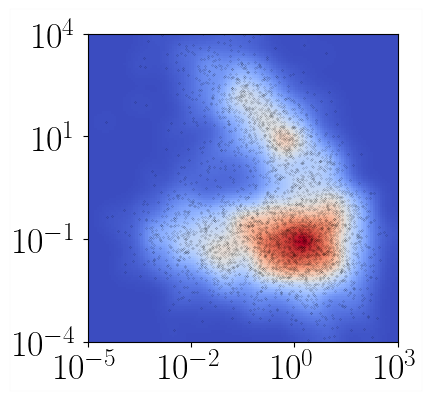

In [141]:
mpl.rcParams.update(mpl.rcParamsDefault)
warnings.filterwarnings('ignore') #--- get rid of warnings

rc('text', usetex=True)
font = {'size'   : 26}
matplotlib.rc('font', **font)

#---------------------------
#--- compute threshold n_th
#---------------------------

def PLOT(edges, hist, cdf, title ):
    #--- plot
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
#    plt.xlim(1e-13,1)
#    plt.ylim(1e-1,1e13)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('nij')
    plt.ylabel('P(nij)')
    plt.title( title )
    plt.plot(edges[:-1],hist,'.-')
    
    plt.subplot(1,2,2)
#    plt.xlim(1e-13,1)
#    plt.ylim(1e-3,1)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('nij')
    plt.ylabel('cdf')
    plt.plot(edges[:-1],cdf,'.-')
    plt.plot([n_thresh for i in edges[:-1]], cdf)
#---    
def HIST( nij, nbins ):
    #--- histograms
    nij_TxR = nij['T*']*nij['R*']
    hist, edges = np.histogram( nij_TxR,
                            bins=np.logspace(np.log(nij_TxR.min()),np.log(nij_TxR.max()),nbins),
                            density=True)
    #--- accumulated
    cdf, edges = np.histogram( nij_TxR,
                           bins=np.logspace(np.log(nij_TxR.min()),np.log(nij_TxR.max()),nbins,endpoint=True))
    cdf=np.cumsum(cdf)
    #assert cdf[-1] == len(nij_TxR), '%s,%s'%(cdf[-1], len(nij_TxR))
    N = 1.0 * len(nij_TxR)
    cdf = cdf / N
    return edges, hist, cdf

def reset_xticks(nn,ax,(TMIN,TMAX)):
    ax.set_xticks( np.linspace(ax.axis()[0],ax.axis()[1],nn) ) 
    labels=np.linspace(TMIN,TMAX,nn)
    labels = [r'$10^{%i}$'%i for i in labels]
    ax.set_xticklabels(labels)

def reset_yticks(nn,ax,(RMIN,RMAX)):
    ax.set_yticks( np.linspace(ax.axis()[2],ax.axis()[3],nn) ) 
    labels=np.linspace(RMIN,RMAX,nn)
    labels = [r'$10^{%i}$'%i for i in labels]
    ax.set_yticklabels(labels)
                 

def GetTrigListLoHi( nij_trig, col, (tlo,thi), swarm_lohi ):
    list_of_mothers = nij_trig.groupby(by='Parent_id').groups.keys() 
    list_of_mothers.sort()
    tmp_df = swarm_lohi.loc[ list_of_mothers ]
    tmp_df = tmp_df[ (tmp_df[ col ] >= tlo) & 
                 (tmp_df[ col ] < thi) ]
    return nij_trig[ pd.DataFrame([nij_trig['Parent_id'] == i for i in tmp_df.index]).any() ]

def GetInterpolatedData( df0, (TMIN,TMAX),(RMIN,RMAX) ):
    nbins_per_decade = 16
    nbins_x=nbins_y=int(TMAX-TMIN)*nbins_per_decade
    df=df0.copy()

    df['T*']=df[ 'T*' ].apply(lambda x: log(x,10))
    df['R*']=df[ 'R*' ].apply(lambda x: log(x,10))
    heatmap, xedges, yedges = np.histogram2d( df[ 'T*' ], df[ 'R*'], bins=[np.linspace(TMIN,TMAX,nbins_x+1), np.linspace(RMIN,RMAX,nbins_y+1)], normed=True)
    heatmap *= len( df )
    heatmap = gaussian_filter( heatmap, sigma = nbins_per_decade/4 )
    return heatmap

def GetDistance( df1, df2 ):
    df_sq = (np.array( df1['x(km)'] ) - np.array( df2['x(km)'] ) ) ** 2 + \
            (np.array( df1['y(km)'] ) - np.array( df2['y(km)'] ) ) ** 2 + \
            (np.array( df1['z(km)'] ) - np.array( df2['z(km)'] ) ) ** 2 
    return pd.Series( df_sq ** 0.5 )

def RemovePair( dff, cs, catalog ):
    pref = 1.0 / 3600.0 / 24 #--- daily
    df = dff.copy()
    
    series_r = GetDistance(catalog.loc[df['Parent_id']],catalog.loc[df['Event_id']])
     
#    series_r = pd.Series(np.array( catalog.loc[df['Parent_id']]['r(km)'] ) -\
#                         np.array( catalog.loc[df['Event_id']]['r(km)'] ) )
    assert len(series_r[series_r==np.nan]) == 0
    df['R'] = series_r.copy() #abs()

    series_t = pd.Series(np.array( catalog.loc[df['Event_id']]['date'] ) -\
                         np.array( catalog.loc[df['Parent_id']]['date'] ) )
    df['T'] = series_t.apply(lambda x:x.total_seconds()*pref)
    assert len ( df[ df['R'] == 0.0 ] ) == 0, '%s'%display( df[ df['R'] == 0.0 ] )
    assert len ( df[ df['T'] == 0.0 ] ) == 0, '%s'%display( df[ df['T'] == 0.0 ] )
    return df [ df[ 'R' ] <= df[ 'T' ] * cs ], df [ df[ 'R' ] > df[ 'T' ] * cs ]



#--------------------
#----- set parameters
#--------------------
#--- set quantile
quantile = 0.05 #new_quantile #0.050
#--- wave speed
cs = 3 * (24*3600) #--- km per day
#--- cut-off time
dt_cut = 0.0 #60.0 #--- day
#--- plot scattered
TMIN=-5
TMAX=3
RMIN=-4
RMAX=4


#--------------------
#----- subset (the same as trig. analysis)
#--------------------
swarm_lohi = DataFrameSubSet( swarm, #--- complete catalog
                             'magnitude', 
                             ( mc, sys.maxint ) ) 
swarm_lohi = GetCartesian( swarm_lohi )
swarm_lohi.reset_index(inplace=True,drop=True)


#--------------------
#--- store actual data in a dataframe
#--------------------
rows, cols = N_sparse.nonzero()
tlist = T_sparse[rows, cols].toarray()[0]
rlist = R_sparse[rows, cols].toarray()[0]
nij = pd.DataFrame({'Event_id':cols, 'Parent_id':rows,'T*':tlist,'R*':rlist})

#--------------------
#--- store random data in a dataframe
#--------------------
nij_rnd = {}
for i in xrange(nsamp):
    rows, cols = N_sparse_rnd[i].nonzero()
    tlist = T_sparse_rnd[i][rows, cols].toarray()[0]
    rlist = R_sparse_rnd[i][rows, cols].toarray()[0]
    nnn = len(cols)
    nij_rnd[i] = pd.DataFrame({'Event_id':cols, 'Parent_id':rows,'T*':tlist,'R*':rlist},index=range(i*nnn,(i+1)*nnn))


#--------------------------------------------
#----- only include mother events with 
#----- t_mother between (t_lo, t_hi) 
#--------------------------------------------
#--- actual data
#--- remove pairs with r > cs.t
nij, nij_removed = RemovePair( nij, cs, swarm_lohi )
myTlohi = Tlohi(swarm_lohi['date'].min()+datetime.timedelta(days=dt_cut), #--- set cut-off time
               swarm_lohi['date'].max()+datetime.timedelta(days=-dt_cut)
               )
nij = GetTrigListLoHi( nij, 'date',  #--- t_mother > t_lo
                       ( myTlohi.lo, myTlohi.hi ), 
                           swarm_lohi)
nij.reset_index(inplace=True, drop=True)

#--- random data
#for i in xrange(nsamp):
#    nij_rnd = RemovePair( nij_rnd, cs, swarm_shuffled )
#    nij_rnd = GetTrigListLoHi( nij_rnd, 'date', 
#                       ( myTlohi.lo, myTlohi.hi ), 
#                           swarm_shuffled)
#    nij_rnd.reset_index(inplace=True, drop=True)

#--- compute threshold
N_thresh = []
frames = []
for i in xrange(nsamp):
    frames.append(nij_rnd[i])
    #--- plot histograms for random data
    edges, hist, cdf = HIST( nij_rnd[i], 1024 )
#    edges = 0.5*(edges[:-1]+edges[1:])
    N_thresh.append(edges[:-1][cdf>quantile][0])
#n_thresh = np.mean(N_thresh)
#print 'n_th=%2.1e+%2.1e' %(n_thresh,np.std(N_thresh) / nsamp ** 0.5)
Nij_rnd = pd.concat([nij_rnd[int(np.random.random()*nsamp)]]) #frames)


#--- distribution of nij (actual data)
edges_actual, hist_actual, cdf_actual = HIST( nij, 1024 )
#edges_actual = 0.5*(edges_actual[:-1]+edges_actual[1:])
#PLOT(edges, hist, cdf, 'random')


#--------------------
#--- plot scattered
#--------------------
fig = plt.figure(figsize=(4,4))


#--------------------
#--- interpolated data
#--------------------
#for nn, index, title in zip([ nij, Nij_rnd ],xrange(2),['actual','randomized']):
for nn, index, title in zip([ nij ],xrange(2),['actual']):
    ax = fig.add_subplot(111) #,2,index+1)
    #--- interpolate
    heatmap=GetInterpolatedData(nn,(TMIN,TMAX),(RMIN,RMAX))
    ax.pcolormesh(heatmap.T,cmap='coolwarm')
    #---
#    ax.set_xlabel('T*')
#    ax.set_ylabel('R*')
#    ax.set_title(title)
    ##--- reset x-ticks
    
    reset_xticks(4,ax,(TMIN,TMAX))
    #--- reset y-ticks
    reset_yticks(4,ax,(RMIN,RMAX))
    #--- nij must be within limits
    nij_copy = nn.copy()
    nij_copy=nij_copy[(nij_copy['T*'] >= 10**TMIN ) &
    (nij_copy['T*'] < 10**TMAX ) &
    (nij_copy['R*'] >= 10**RMIN ) &
    (nij_copy['R*'] < 10**RMAX )]
    #--- mapping
    xx=ax.axis()[0]+(ax.axis()[1]-ax.axis()[0])*(np.log10(nij_copy['T*'])-TMIN)/(TMAX-TMIN)
    yy=ax.axis()[2]+(ax.axis()[3]-ax.axis()[2])*(np.log10(nij_copy['R*'])-RMIN)/(RMAX-RMIN)
    ax.set_xlim(ax.axis()[0],ax.axis()[1])
    ax.set_ylim(ax.axis()[2],ax.axis()[3])
    #--- plot                 
    DrawFrame(ax, (0.25,0.08),(0.16,0.08),0.01)
    ax.scatter(xx,
              yy,
               alpha=1,color='black',s=0.01)
    #--- draw the separation line
#    xx=ax.axis()[0]+(ax.axis()[1]-ax.axis()[0])*(np.log10(nij_copy['T*'])-TMIN)/(TMAX-TMIN)
#    yy=ax.axis()[2]+(ax.axis()[3]-ax.axis()[2])*(np.log10(n_thresh/nij_copy['T*'])-RMIN)/(RMAX-RMIN)
#    print len(xx)
#    xx=xx[0:-1:300]
#    yy=yy[0:-1:300]
#    print len(xx)
#    ax.plot( xx, yy,'-.',color='white',linewidth=1)
    
#fig.savefig('%s/densityMaps.png'%DIR_OUTPT_figs,bbox_inches='tight',dpi=150)
#---
mpl.rcParams.update(mpl.rcParamsDefault)
warnings.filterwarnings('ignore') #--- get rid of warnings
rc('text', usetex=True)
font = {'size'   : 20}
matplotlib.rc('font', **font)

### Distributions of $n_{ij}$

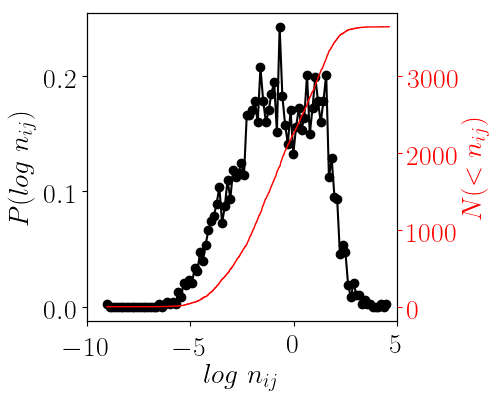

In [142]:
#--- histogram
nn=np.log10(nij['R*']*nij['T*'])
nmin=nn.min()
nmax=nn.max()
bins=np.linspace(nmin,nmax,int(nmax-nmin)*8)
hist, edge = np.histogram(nn,bins=bins,normed=True)

#--- accumulated histogram
slist=np.array(nn)
slist.sort()
N = len(slist)
d = histogramACCUMLTD( slist.tolist() )
keys=d.keys()
keys.sort()

xx=[];yy=[]
for ikey in keys:
    xx.append(d[ikey][0])
    yy.append(d[ikey][2])

#------------
#--- plot
#------------    
fig= plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
ax.set_xlabel('$log~n_{ij}$')
ax.set_ylabel('$P(log~n_{ij})$')
(nmin,nmax) = (min(slist),max(slist))
ax.set_xlim(floor(nmin),ceil(nmax))
#ax.set_xlim(-7,1)
#ax.set_ylim(0,0.6)
#ax.set_xscale('log')
#ax.set_yscale('log')
ax.plot(edge[:-1],hist,'-o',color='black')

ax2 = ax.twinx()
ax2.plot(xx,yy,
        linestyle='-', drawstyle='steps-post',color='red',
        linewidth=1.0) #--- accumulated
#ax2.set_xlim(-7,1)
#ax2.set_ylim(0,1200)

ax2.tick_params(axis='y',colors='red')
ax2.set_ylabel('$N(<n_{ij})$',color='red')

np.save('actual',np.c_[edge[:-1],hist])
np.save('acc_actual',np.c_[xx,yy])


#fig.savefig('%s/pn_actual.png'%DIR_OUTPT_figs,bbox_inches='tight')
plt.show()

### declustering

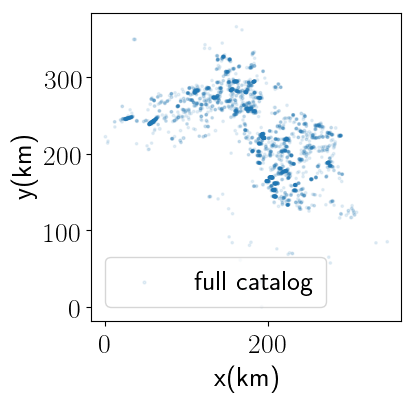

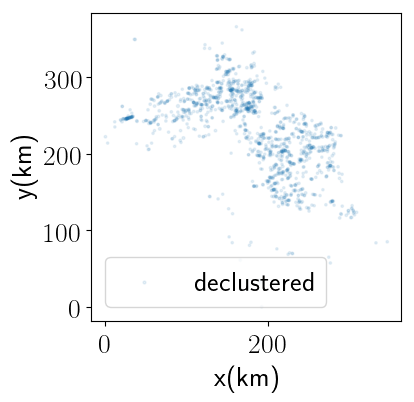

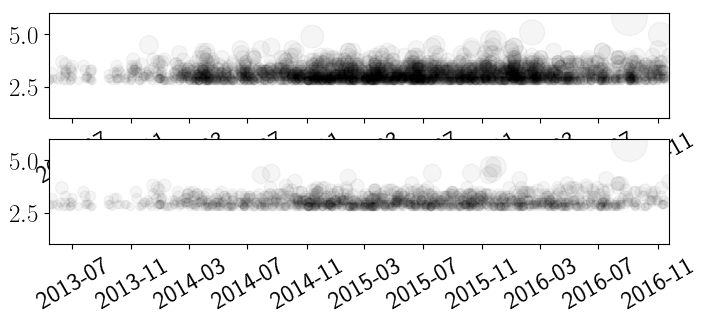

In [143]:
def GetBackground(nij,nij_removed,n_thresh,swarm_lohi):    
    #---------------------
    #--- triggering part of nij
    #---------------------
    nij_trig=nij[nij['T*']*nij['R*']<=n_thresh]
    df_triggered = swarm_lohi.iloc[nij_trig['Event_id']]

    #---------------------
    #--- background part of nij
    #---------------------
    nij_background=nij[nij['T*']*nij['R*']>n_thresh]
    nn = len(nij_background)
    nij_background = nij_background.append(nij_removed,verify_integrity=False) #--- append removed part
    assert len(nij_background) == nn + len(nij_removed)

    #---------------------
    #--- background events
    #---------------------
    background_child = list(set(nij_background['Event_id'])) #--- children
#
    nij_copy = nij.copy()
    Nij = nij_copy.append(nij_removed)
    background_root  = list(set(Nij['Parent_id'])-set(Nij['Event_id'])) #--- root
#
    background = background_root+background_child #--- total
    assert len(background) == len(set(background)) #--- assert no overlap
#
    df_background = swarm_lohi.iloc[background]

    #---------------------
    #--- assertion
    #---------------------
    assert len(df_triggered) + len(df_background) == len(swarm_lohi), '%s != %s' %(len(df_triggered) + len(df_background),len(swarm_lohi))
    return df_background,  df_triggered

#n_thresh=1.0 #--- comment out if passed in the command line
df_background,  df_triggered = GetBackground(nij,nij_removed,n_thresh,swarm_lohi)  

#---------------------
#--- plot
#---------------------
swarm_lohi.plot.scatter('x(km)', 'y(km)',figsize=(4,4),
                         alpha=0.1,s=swarm_lohi['magnitude'],label='full catalog')
#
#
df_background.plot.scatter('x(km)','y(km)', figsize=(4,4),
                        alpha=0.1,s=df_background['magnitude'],label='declustered')

fig = plt.figure(figsize=(8,3))#,dpi=150)
ax1=fig.add_subplot(211)

#plt.xlabel('Time')
#plt.ylabel('M')

ax1.set_ylim(1,6)
ax1.set_xlim(swarm_lohi['date'].min(),swarm_lohi['date'].max())

ax1.tick_params(axis='both',labelsize=18)
ax1.tick_params(axis='x',rotation=30)

ax1.scatter(swarm_lohi['date'],swarm_lohi['magnitude'],
            s=2*np.exp(swarm_lohi['magnitude']),
            alpha=0.04,color='black')

#
#
ax2=fig.add_subplot(212)
ax2.set_ylim(1,6)
ax2.set_xlim(swarm_lohi['date'].min(),swarm_lohi['date'].max())

ax2.tick_params(axis='both',labelsize=18)
ax2.tick_params(axis='x',rotation=30)


ax2.scatter(df_background['date'],df_background['magnitude'],
            s=2*np.exp(df_background['magnitude']),
            alpha=0.04,color='black')


### triggering analysis

In [149]:
def perturb(df_background):
    df = df_background.copy()
    tt=np.array(df['date'].to_list())
    dt=np.array(map(lambda x:x.total_seconds(),tt[1:]-tt[:-1]))
    fluc = 0.99 * np.min(dt[dt!=0.0])
#    print 'sigma=',fluc
    dt=np.random.normal(scale=fluc,size=len(df))
#    print 'tmax=',np.max(dt)
#    print 'dt=',pd.to_timedelta('%ss'%np.max(dt))
    dt=map(lambda x:pd.to_timedelta('%ss'%x),dt)
    df['date'] += pd.DataFrame(dt,columns=['date'])['date']
    return df

def perturbXY(df_background,rmat):
    df = df_background.copy()
    fluc = 0.99 * rmat[rmat!=0.0].min()
#    print 'sigma=',fluc
    dx=np.random.normal(scale=fluc,size=len(df))
    dy=np.random.normal(scale=fluc,size=len(df))
#    print 'tmax=',np.max(dt)
#    print 'dt=',pd.to_timedelta('%ss'%np.max(dt))
#    dt=map(lambda x:pd.to_timedelta('%ss'%x),dt)
    df['x(km)'] += pd.DataFrame(dx,columns=['x(km)'])['x(km)']
    df['y(km)'] += pd.DataFrame(dy,columns=['y(km)'])['y(km)']
    return df

def perturb_m(df_background):
    df = df_background.copy()
    fluc = 0.1 #0.99 * rmat[rmat!=0.0].min()
    dx=np.random.normal(scale=fluc,size=len(df))
    df['magnitude'] += pd.DataFrame(dx,columns=['magnitude'])['magnitude']
    return df

df_background.reset_index(inplace=True,drop=True)
#
df_background_pertubed = perturb(df_background)
df_background_pertubed = perturbXY(df_background_pertubed,rmat)
df_background_pertubed = perturb_m(df_background_pertubed)
#
N_sparse, (T_sparse,tmat), (R_sparse,rmat), m_mat = vectorizedAnalysis( df_background_pertubed )
N_sparse_rnd, (T_sparse_rnd,tmat_rnd), (R_sparse_rnd,rmat_rnd), junk = GetNij(rmat,tmat,m_mat,df_background)


setting up tmat:2.01688504219 s
setting up rmat:3.32906413078 s
setting up m_mat:1.30175995827 s
setting up NIJ:0.250952959061 s


### density plots

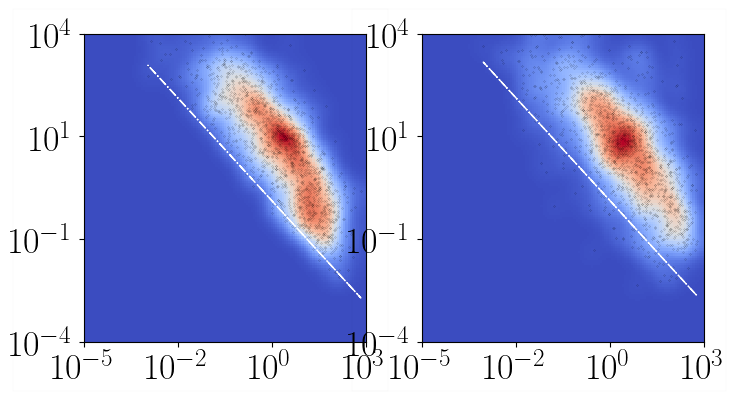

In [150]:
mpl.rcParams.update(mpl.rcParamsDefault)
warnings.filterwarnings('ignore') #--- get rid of warnings

rc('text', usetex=True)
font = {'size'   : 26}
matplotlib.rc('font', **font)



#--------------------
#----- set parameters
#--------------------
#--- set quantile
quantile = 0.05 #new_quantile #0.050
#--- wave speed
cs = 3 * (24*3600) #--- km per day
#--- cut-off time
dt_cut = 0.0 #60.0 #--- day
#--- plot scattered
TMIN=-5
TMAX=3
RMIN=-4
RMAX=4


#--------------------
#--- store actual data in a dataframe
#--------------------
rows, cols = N_sparse.nonzero()
tlist = T_sparse[rows, cols].toarray()[0]
rlist = R_sparse[rows, cols].toarray()[0]
nij = pd.DataFrame({'Event_id':cols, 'Parent_id':rows,'T*':tlist,'R*':rlist})

#--------------------
#--- store random data in a dataframe
#--------------------
#nij_rnd = {}
#for i in xrange(nsamp):
rows, cols = N_sparse_rnd.nonzero()
tlist = T_sparse_rnd[rows, cols].toarray()[0]
rlist = R_sparse_rnd[rows, cols].toarray()[0]
nnn = len(cols)
nij_rnd= pd.DataFrame({'Event_id':cols, 'Parent_id':rows,'T*':tlist,'R*':rlist},index=range(i*nnn,(i+1)*nnn))


#--------------------------------------------
#----- only include mother events with 
#----- t_mother between (t_lo, t_hi) 
#--------------------------------------------
#--- actual data
#--- remove pairs with r > cs.t
nij, nij_removed = RemovePair( nij, cs, df_background_pertubed )

#--- distribution of nij (actual data)
edges_actual, hist_actual, cdf_actual = HIST( nij, 1024 )


#--------------------
#--- plot scattered
#--------------------
fig = plt.figure(figsize=(8,4))


#--------------------
#--- interpolated data
#--------------------
for nn, index, title in zip([ nij, nij_rnd ],xrange(2),['actual','randomized']):
#for nn, index, title in zip([ nij ],xrange(2),['actual']):
    ax = fig.add_subplot(1,2,index+1)
    #--- interpolate
    heatmap=GetInterpolatedData(nn,(TMIN,TMAX),(RMIN,RMAX))
    ax.pcolormesh(heatmap.T,cmap='coolwarm')
    #---
#    ax.set_xlabel('T*')
#    ax.set_ylabel('R*')
#    ax.set_title(title)
    ##--- reset x-ticks
    
    reset_xticks(4,ax,(TMIN,TMAX))
    #--- reset y-ticks
    reset_yticks(4,ax,(RMIN,RMAX))
    #--- nij must be within limits
    nij_copy = nn.copy()
    nij_copy=nij_copy[(nij_copy['T*'] >= 10**TMIN ) &
    (nij_copy['T*'] < 10**TMAX ) &
    (nij_copy['R*'] >= 10**RMIN ) &
    (nij_copy['R*'] < 10**RMAX )]
    #--- mapping
    xx=ax.axis()[0]+(ax.axis()[1]-ax.axis()[0])*(np.log10(nij_copy['T*'])-TMIN)/(TMAX-TMIN)
    yy=ax.axis()[2]+(ax.axis()[3]-ax.axis()[2])*(np.log10(nij_copy['R*'])-RMIN)/(RMAX-RMIN)
    ax.set_xlim(ax.axis()[0],ax.axis()[1])
    ax.set_ylim(ax.axis()[2],ax.axis()[3])
    #--- plot                 
    DrawFrame(ax, (0.25,0.08),(0.16,0.08),0.01)
    ax.scatter(xx,
              yy,
               alpha=1,color='black',s=0.01)
    #--- draw the separation line
    xx=ax.axis()[0]+(ax.axis()[1]-ax.axis()[0])*(np.log10(nij_copy['T*'])-TMIN)/(TMAX-TMIN)
    yy=ax.axis()[2]+(ax.axis()[3]-ax.axis()[2])*(np.log10(n_thresh/nij_copy['T*'])-RMIN)/(RMAX-RMIN)
#    print len(xx)
#    xx=xx[0:-1:300]
#    yy=yy[0:-1:300]
#    print len(xx)
    ax.plot( xx, yy,'-.',color='white',linewidth=1)
    
#fig.savefig('%s/densityMaps.png'%DIR_OUTPT_figs,bbox_inches='tight',dpi=150)
#---
mpl.rcParams.update(mpl.rcParamsDefault)
warnings.filterwarnings('ignore') #--- get rid of warnings
rc('text', usetex=True)
font = {'size'   : 20}
matplotlib.rc('font', **font)

### Distributions of $n_{ij}$

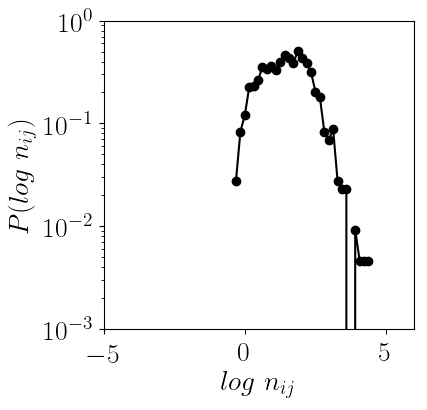

In [151]:
#--- histogram
nn=np.log10(nij['R*']*nij['T*'])
nmin=nn.min()
nmax=nn.max()
bins=np.linspace(nmin,nmax,int(nmax-nmin)*8)
hist, edge = np.histogram(nn,bins=bins,normed=True)

#--- accumulated histogram
slist=np.array(nn)
slist.sort()
N = len(slist)
d = histogramACCUMLTD( slist.tolist() )
keys=d.keys()
keys.sort()

xx=[];yy=[]
for ikey in keys:
    xx.append(d[ikey][0])
    yy.append(d[ikey][2])

#------------
#--- plot
#------------    
fig= plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
ax.set_xlabel('$log~n_{ij}$')
ax.set_ylabel('$P(log~n_{ij})$')
(nmin,nmax) = (min(slist),max(slist))
ax.set_xlim(floor(nmin),ceil(nmax))
ax.set_xlim(-5,6)
ax.set_ylim(1e-3,1)
#ax.set_xscale('log')
ax.set_yscale('log')
ax.plot(edge[:-1],hist,'-o',color='black')

#ax2 = ax.twinx()
# ax2.plot(xx,yy,
#         linestyle='-', drawstyle='steps-post',color='red',
#         linewidth=1.0) #--- accumulated
# #ax2.set_xlim(-7,1)
# #ax2.set_ylim(0,1200)

# ax2.tick_params(axis='y',colors='red')
# ax2.set_ylabel('$N(<n_{ij})$',color='red')

np.save('nij_declustered',nn)


#fig.savefig('%s/pn_actual.png'%DIR_OUTPT_figs,bbox_inches='tight')
plt.show()

### Distributions of shuffled $n_{ij}$

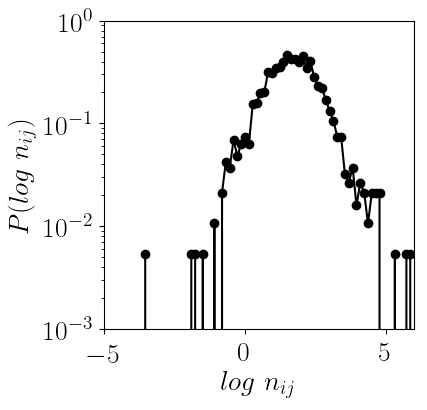

In [152]:
#--- histogram
nn=np.log10(nij_rnd['R*']*nij_rnd['T*'])
#nn=nn[nn>n_thresh]
nmin=nn.min()
nmax=nn.max()
bins=np.linspace(nmin,nmax,int(nmax-nmin)*8)
hist, edge = np.histogram(nn,bins=bins,normed=True)

#--- accumulated histogram
slist=np.array(nn)
slist.sort()
N = len(slist)
d = histogramACCUMLTD( slist.tolist() )
keys=d.keys()
keys.sort()

xx=[];yy=[]
for ikey in keys:
    xx.append(d[ikey][0])
    yy.append(d[ikey][2])

#------------
#--- plot
#------------    
fig= plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
ax.set_xlabel('$log~n_{ij}$')
ax.set_ylabel('$P(log~n_{ij})$')
(nmin,nmax) = (min(slist),max(slist))
ax.set_xlim(floor(nmin),ceil(nmax))
ax.set_xlim(-5,6)
ax.set_ylim(1e-3,1)
#ax.set_xscale('log')
ax.set_yscale('log')
ax.plot(edge[:-1],hist,'-o',color='black')

#ax2 = ax.twinx()
#ax2.plot(xx,yy,
#        linestyle='-', drawstyle='steps-post',color='red',
#        linewidth=1.0) #--- accumulated
#ax2.set_xlim(-7,1)
#ax2.set_ylim(0,1200)

#ax2.tick_params(axis='y',colors='red')
#ax2.set_ylabel('$N(<n_{ij})$',color='red')

np.save('nij_shuffled',nn)


##fig.savefig('%s/pn_shuffled.png'%DIR_OUTPT_figs,bbox_inches='tight')
plt.show()